In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import datetime
import os
import csv
import seawater.eos80 as sw
import scipy.io

from matplotlib import cm
from numpy import linspace

import pandas as pd


import cartopy


mpl.style.use('seaborn-muted')
mpl.rc('font', family ='Segoe UI Symbol')

/tmp/ipykernel_106201/3719038308.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [2]:
############### start running code form here if got all csv files ready ##########################

################################ csv files #############################################  

import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"

for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    # if os.path.basename(filename) != exclude_file:
    # read the csv file
    first = True
    try:
        csv_filehandle = open(filename)
        # print(filename)
        csvfile = csv.reader(csv_filehandle)
    except:
        # print("load fail")
        continue

    # get the file name without the directory path and file extension
    fn = os.path.splitext(os.path.basename(filename))[0]

    # initialize the data structure
    csv_ctd_data_dict[fn] = {}
    
    # Flag variable to check if 'time' column is found
    time_column_found = False
    
    for row in csvfile:
        if first:
            header = row

            first = False
            for i in range(len(row)):
                headers.append(row[i])
                csv_ctd_data_dict[fn][row[i]] = []
                
                # Check if 'time' column exists in the header
                if row[i] == 'time':
                    time_column_found = True

            # If 'time' column is not found, print the error and break
            if not time_column_found:
                print(f"'time' column not found in file: {filename}")
                break

        else:
            for i in range(len(row)):
                csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

    csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}


print(csv_cast_lat_lon)
# for key in csv_ctd_data_dict['cnv_subset_c04_updated'].keys():
#     print(key)

{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariables_ordered_type': {'lat': -65.0629999999

In [3]:
len(csv_cast_lat_lon)

1149

In [4]:
##run this code to order the dictionary by lat & lon. D
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [5]:
max_depth = float('-inf')  # Initialize with negative infinity

# Iterate through top-level keys in the data dictionary
for dataset_key in csv_ctd_data_dict.keys():
    depth_values = csv_ctd_data_dict[dataset_key]['depth']
    max_depth_dataset = max(depth_values)
    
    # Update max_depth if the current dataset's max depth is greater
    if max_depth_dataset > max_depth:
        max_depth = max_depth_dataset

print("Maximum Depth:", max_depth)

Maximum Depth: 4184.780948


In [6]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

/tmp/ipykernel_98836/1363126866.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
/tmp/ipykernel_98836/1363126866.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
/tmp/ipykernel_98836/1363126866.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
/tmp/ipykernel_98836/1363126866.py:53: MatplotlibDeprecationWarning: The get_cmap function was depre

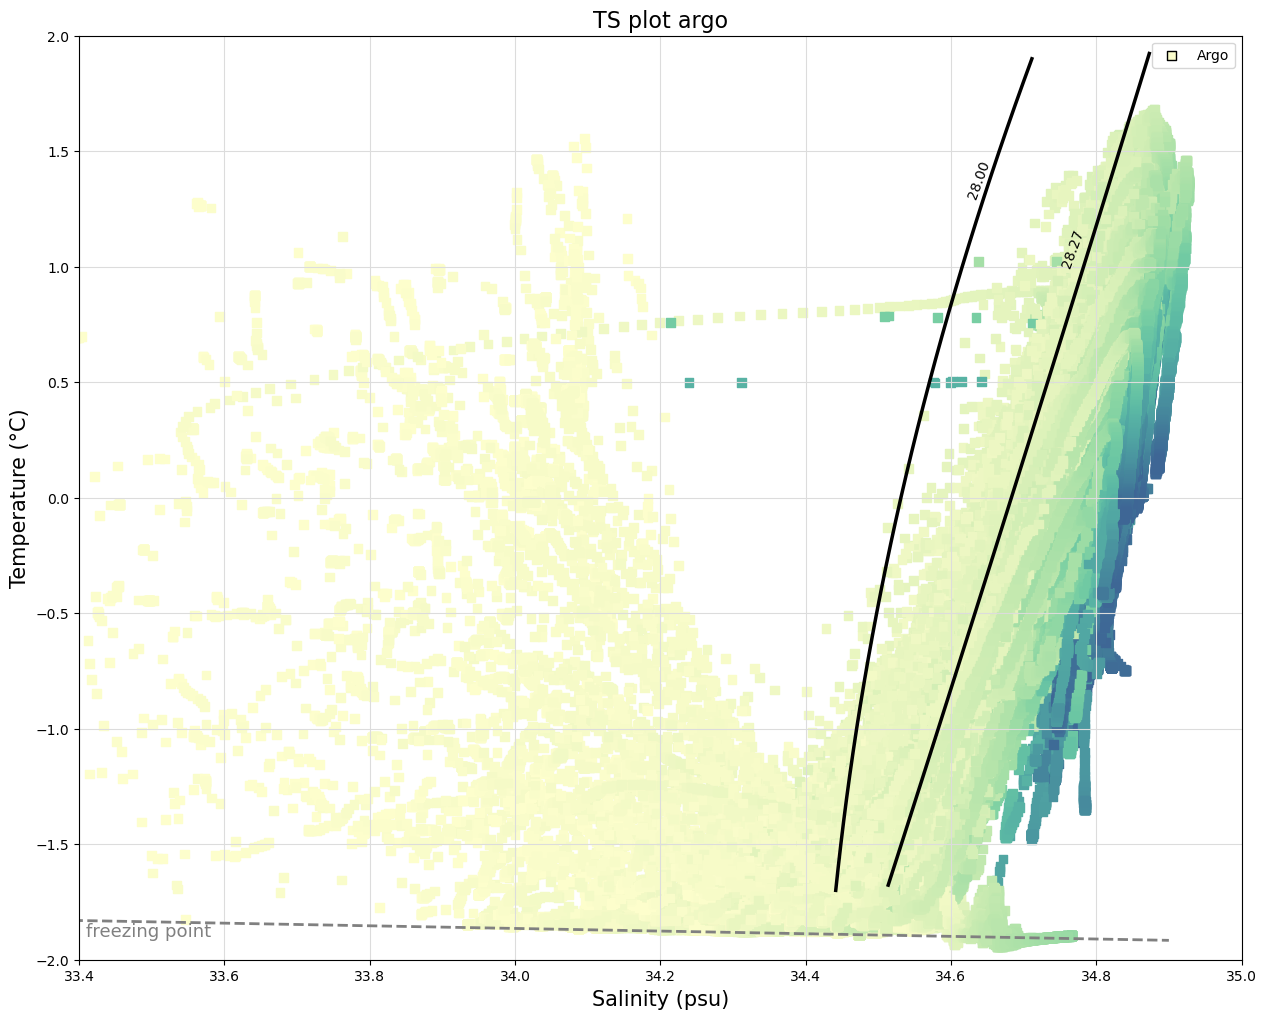

In [15]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
# import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')



# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]



# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
# seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
#                            s=10, c=seals_depth, cmap=cmap_deep, vmax = 3000, marker='o', label='Seals')

# ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
#                            s=40, c=ships_depth, cmap=cmap_deep, vmax = 3000, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature,
                           s=40, c=argo_depth, cmap=cmap_deep, vmax=3000, marker='s', label='Argo')



#plot the x & y values from matlab to put on the neutral density lines    
plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Argo, Seal & Ship CTD casts CD ordered by lat',  fontsize=25)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Add a dynamic title
plt.title(f'TS plot argo', fontsize=16)

plt.show()

/tmp/ipykernel_106201/2734507317.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
/tmp/ipykernel_106201/2734507317.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
/tmp/ipykernel_106201/2734507317.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
/tmp/ipykernel_106201/2734507317.py:54: MatplotlibDeprecationWarning: The get_cmap function was d

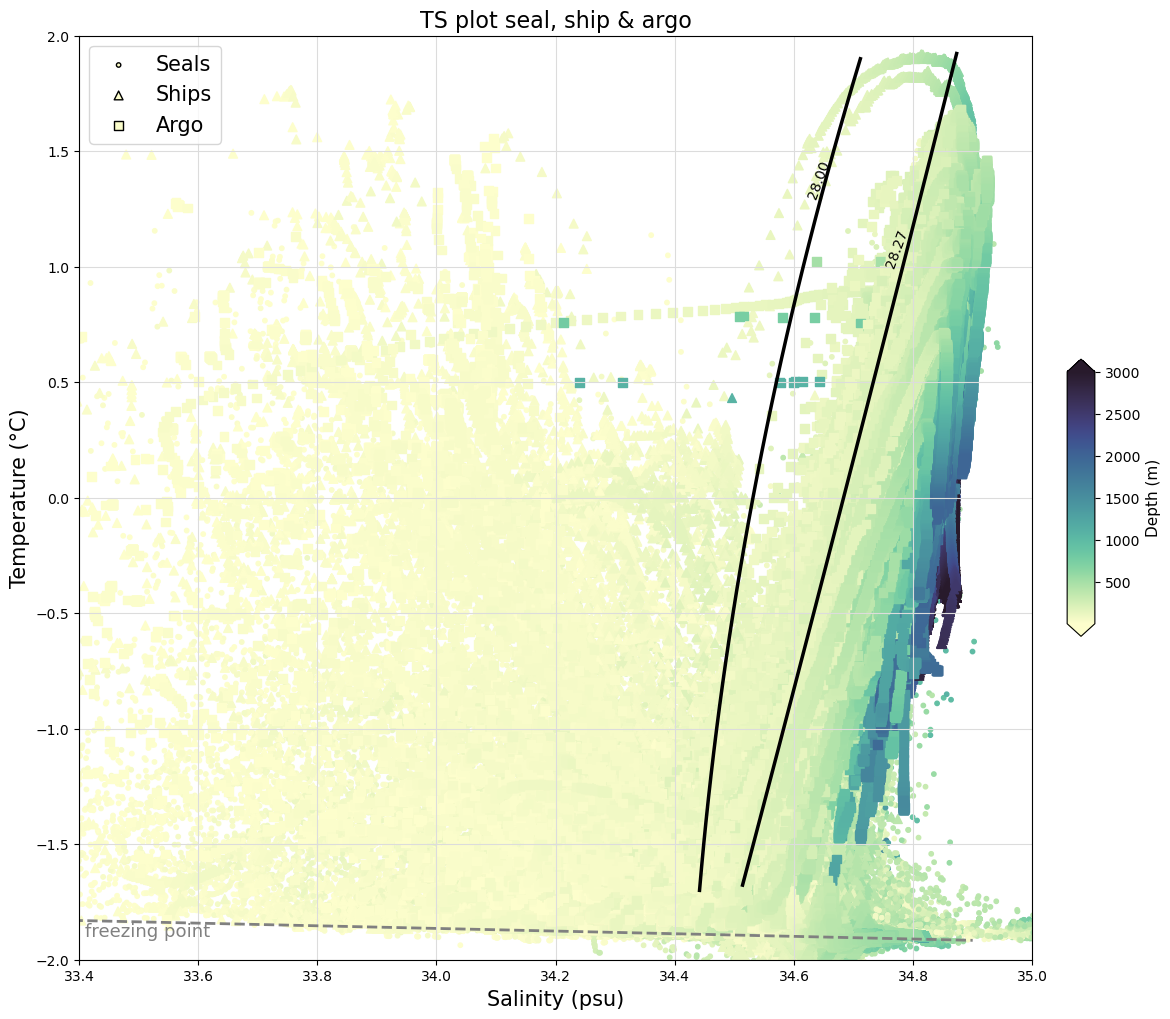

In [10]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
# import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.lines as mlines



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')



# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]



# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=10, c=seals_depth, cmap=cmap_deep, vmax = 3000, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=40, c=ships_depth, cmap=cmap_deep, vmax = 3000, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature,
                           s=40, c=argo_depth, cmap=cmap_deep, vmax=3000, marker='s', label='Argo')



#plot the x & y values from matlab to put on the neutral density lines    
plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Argo, Seal & Ship CTD casts CD ordered by lat',  fontsize=25)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Depth (m)', fontsize=11)



# Create a legend
legend = plt.legend(prop={'size': 15})

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Add a dynamic title
plt.title(f'TS plot seal, ship & argo', fontsize=16)

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\3991593504.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\3991593504.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\3991593504.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sien

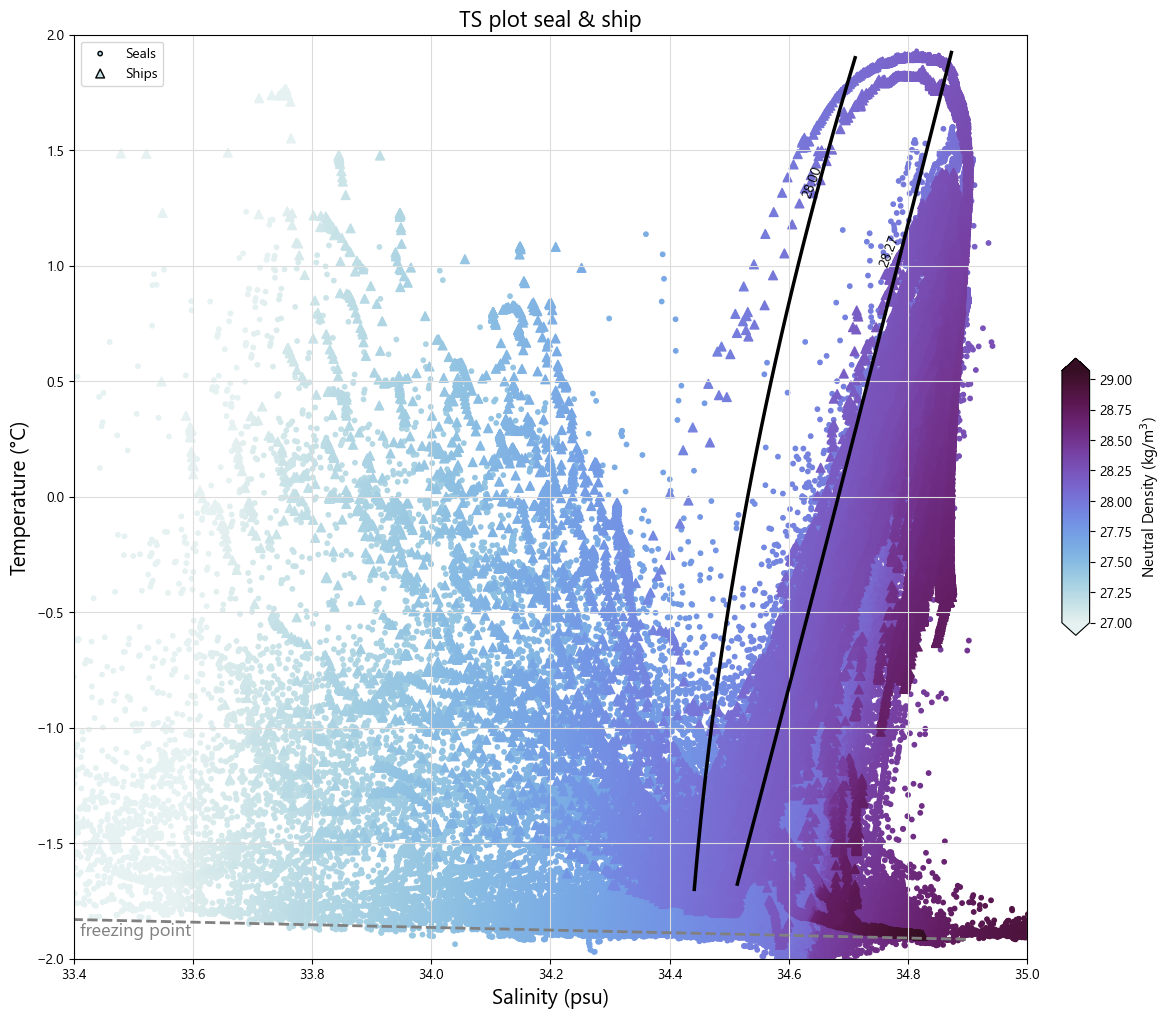

In [25]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')



# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]




# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=10, c=seals_neutral_density, cmap=cmap_dens, vmin = 27, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=40, c=ships_neutral_density, cmap=cmap_dens, vmin = 27, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature, s=40, c=argo_neutral_density, cmap=cmap_dens, vmin=27, marker='s', label='Argo')



#plot the x & y values from matlab to put on the neutral density lines    
plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Seal CTD casts CD ordered by lat',  fontsize=25)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Add a dynamic title
plt.title(f'TS plot seal & ship', fontsize=16)

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\2811274322.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\2811274322.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\2811274322.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sien

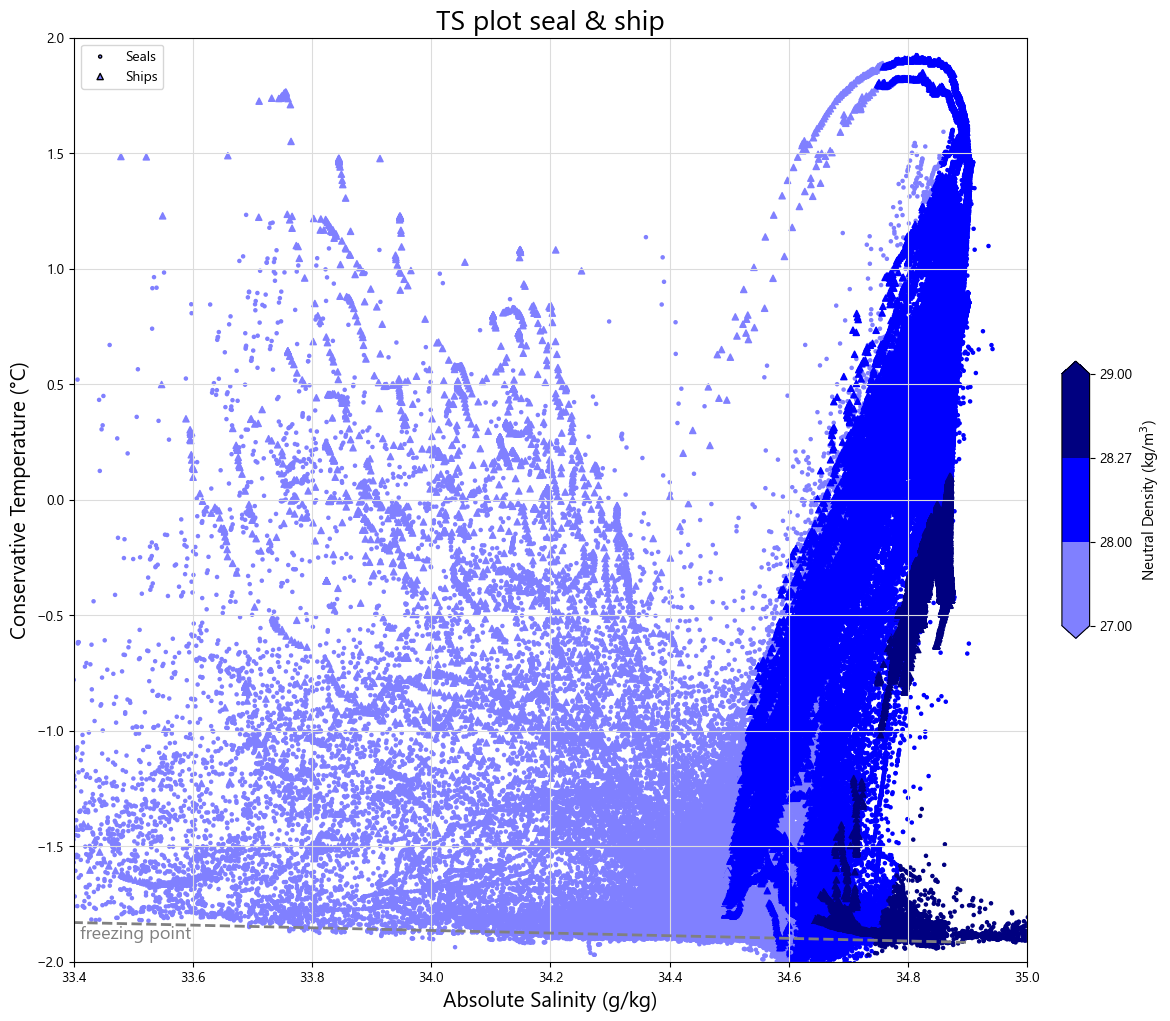

In [62]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin = 27
vmax1 = 28
vmax2 = 28.27
vmax3 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin, vmax1, vmax2, vmax3], cmap_custom.N)






# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]



# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=5, c=seals_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=20, c=ships_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')




#plot the x & y values from matlab to put on the neutral density lines    
# plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
# plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
# plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Add a dynamic title
plt.title(f'TS plot seal & ship', fontsize=20)

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\4105216561.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\4105216561.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\4105216561.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sien

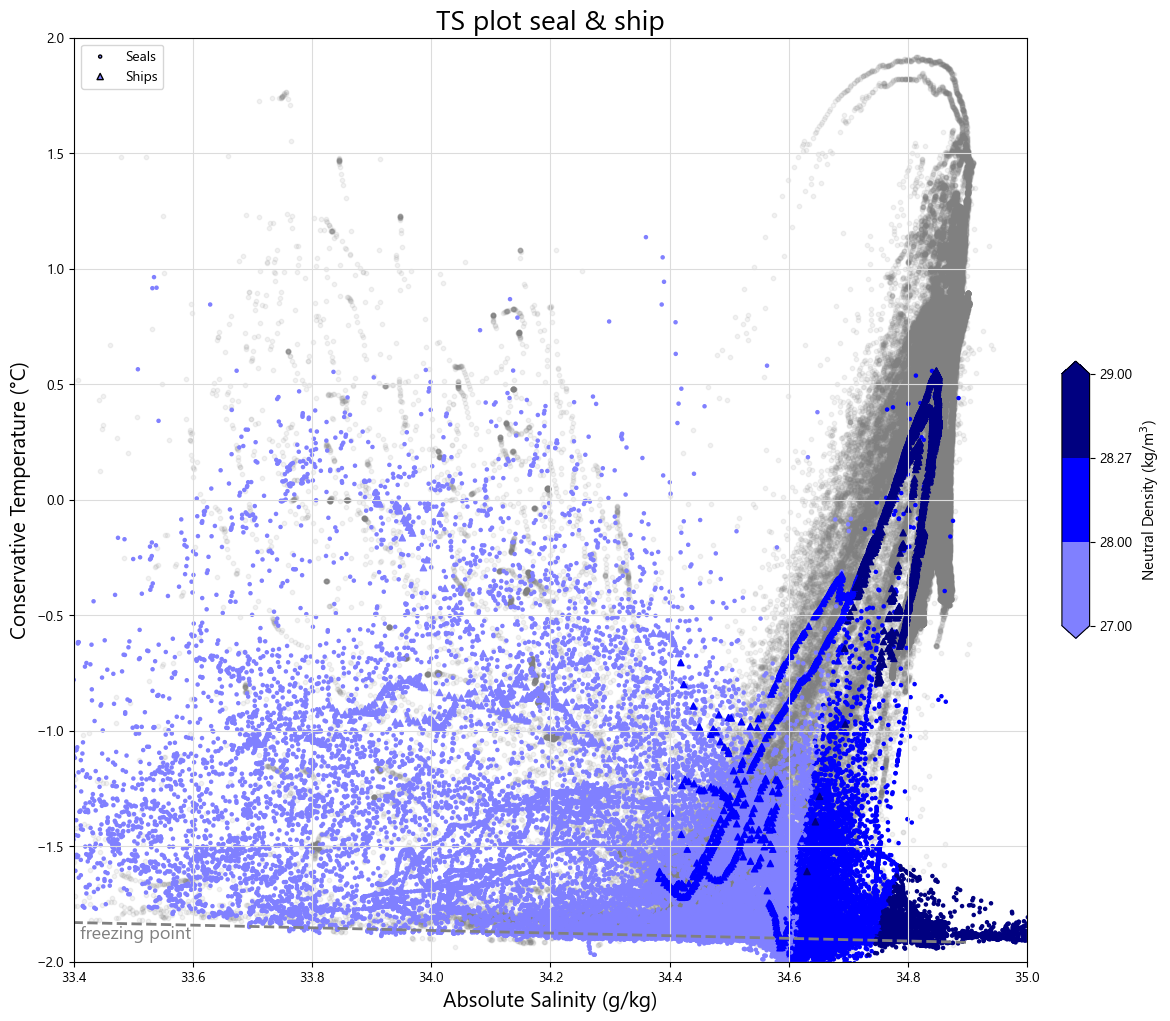

In [118]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)






# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]



# Define the latitude range you want to plot
#on shelf
lat_min = -68
lat_max = -67

# #slope
# lat_min = -67
# lat_max = -66

# #off shelf
# lat_min = -66
# lat_max = -65


#west
lon_min = 63
lon_max = 66

# #central
# lon_min = 66
# lon_max = 69

# #east
# lon_min = 69
# lon_max = 73



# Filter the data based on latitude
seals_indices_in_range = np.where((seals_latitude >= lat_min) & (seals_latitude <= lat_max))[0]
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_depth[seals_indices_in_range]

seals_indices_out_range = np.where((seals_latitude < lat_min) | (seals_latitude > lat_max))[0]
seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_depth[seals_indices_out_range]



ships_indices_in_range = np.where((ships_latitude >= lat_min) & (ships_latitude <= lat_max))[0]
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_depth[ships_indices_in_range]

ships_indices_out_range = np.where((ships_latitude < lat_min) | (ships_latitude > lat_max))[0]
ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_depth[ships_indices_out_range]




# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='grey', alpha=0.1, s=10)

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='grey', alpha=0.1, s=10)


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_neutral_density_in_range, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_neutral_density_in_range, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')


#plot the x & y values from matlab to put on the neutral density lines    
# plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
# plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
# plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Add a dynamic title
plt.title(f'TS plot seal & ship', fontsize=20)

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\1121442866.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\1121442866.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\1121442866.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sien

[1.98017939e+00 3.96033958e+00 5.94048055e+00 ... 3.47605349e+03
 3.47702749e+03 3.47800148e+03]


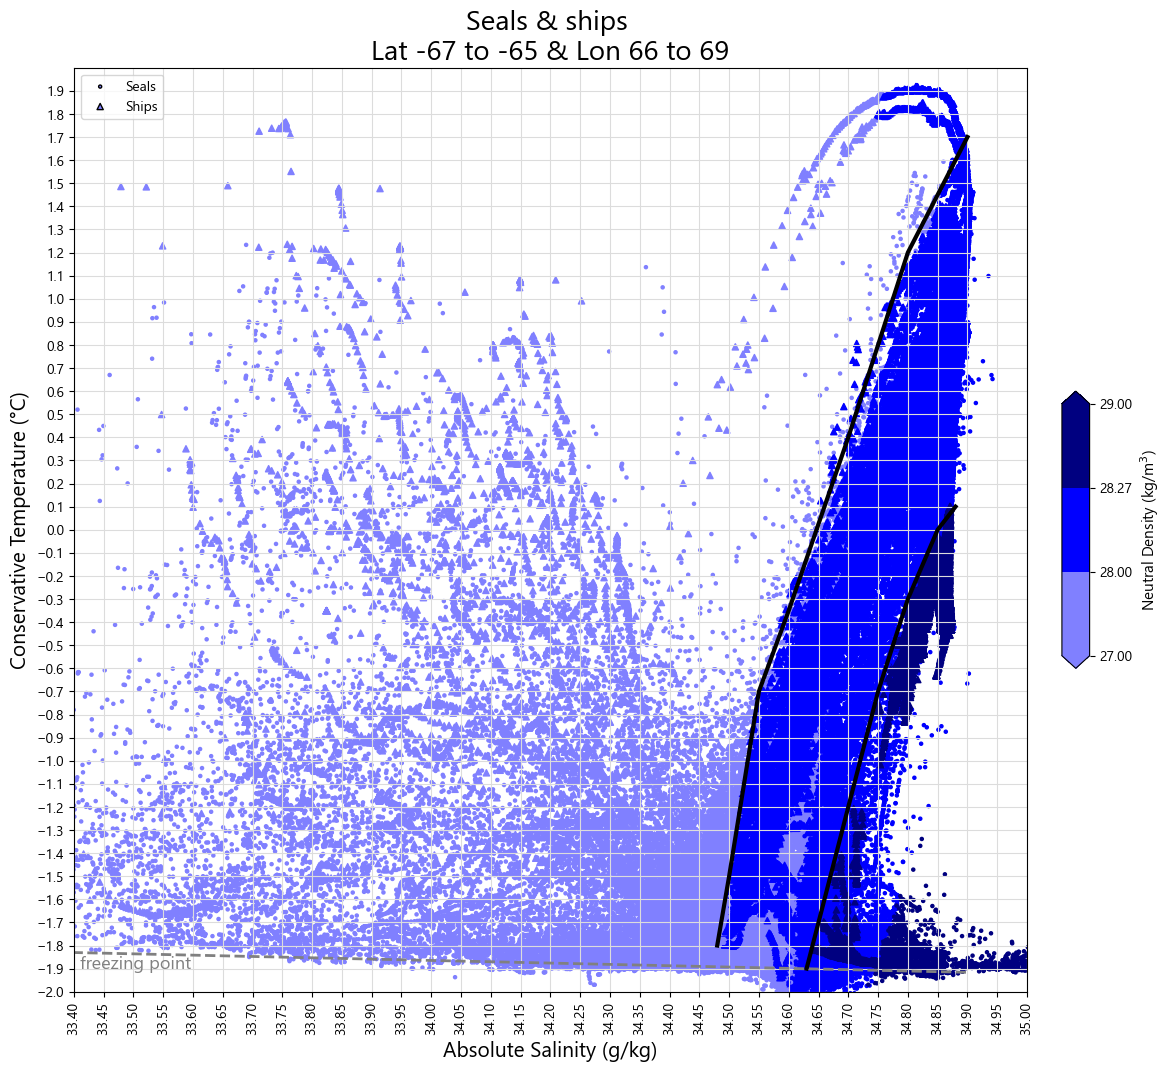

In [99]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)






# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]



# Define the latitude range you want to plot
#on shelf
lat_min = -68
lat_max = -67

# #slope
# lat_min = -67
# lat_max = -66

# #off shelf
# lat_min = -66
# lat_max = -65


#west
lon_min = 63
lon_max = 66

# #central
# lon_min = 66
# lon_max = 69

# #east
# lon_min = 69
# lon_max = 73



# Filter the data based on latitude
seals_indices_in_range = np.where((seals_latitude >= lat_min) & (seals_latitude <= lat_max) &
    (seals_longitude >= lon_min) & (seals_longitude <= lon_max))[0]
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_depth[seals_indices_in_range]

# Check if data exists for in-range conditions, if not, set them to empty arrays
if len(seals_indices_in_range) == 0:
    seals_cons_temperature_in_range = np.array([])
    seals_abs_salinity_in_range = np.array([])
    seals_depth_in_range = np.array([])
    seals_neutral_density_in_range = np.array([])
    seals_time_in_range = np.array([])


seals_indices_out_range = np.where((seals_latitude < lat_min) | (seals_latitude > lat_max) &
    (seals_longitude < lon_min) | (seals_longitude > lon_max))[0]
seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_depth[seals_indices_out_range]



ships_indices_in_range = np.where((ships_latitude >= lat_min) & (ships_latitude <= lat_max) &
    (ships_longitude >= lon_min) & (ships_longitude <= lon_max))[0]
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_depth[ships_indices_in_range]

# Check if data exists for in-range conditions for ships, if not, set them to empty arrays
if len(ships_indices_in_range) == 0:
    ships_cons_temperature_in_range = np.array([])
    ships_abs_salinity_in_range = np.array([])
    ships_depth_in_range = np.array([])
    ships_neutral_density_in_range = np.array([])
    ships_time_in_range = np.array([])


print(ships_time_in_range)

ships_indices_out_range = np.where((ships_latitude < lat_min) | (ships_latitude > lat_max) &
    (ships_longitude < lon_min) | (ships_longitude > lon_max))[0]
ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_depth[ships_indices_out_range]




# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
# seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
#                            color='grey', alpha=0.1, s=5, marker='o')

# ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
#                            color='grey', alpha=0.1, s=20, marker='^')


# seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
#                            s=5, c=seals_neutral_density_in_range, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

# ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
#                            s=20, c=ships_neutral_density_in_range, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')



seals_scatter_in_range = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=5, c=seals_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=20, c=ships_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')


#plot the x & y values from matlab to put on the neutral density lines    
# plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
# plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
# plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xticks(np.arange(33.4,35, 0.05), rotation=90)
plt.yticks(np.arange(-2,2, 0.1))
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Define the points for your contour line
contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_x1, contour_y1 = zip(*contour_points1)

# Plot the contour line
plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')


# Define the points for your contour line
contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_x2, contour_y2 = zip(*contour_points2)

# Plot the contour line
plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
plt.title(f'Seals & ships \nLat {lat_min} to {lat_max} & Lon {lon_min} to {lon_max}', fontsize=20)

plt.show()

In [6]:
# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]


print(seals_longitude)
min(seals_longitude)

[68.27180267 68.27180267 68.27180267 ... 71.407      71.407
 71.407     ]


63.0258

In [169]:
# Define the latitude range you want to plot
# #on shelf
# lat_min = -68
# lat_max = -67

#slope
lat_min = -67
lat_max = -66

# #off shelf
# lat_min = -66
# lat_max = -65


#west
lon_min = 63
lon_max = 66

# #central
# lon_min = 66
# lon_max = 69

# #east
# lon_min = 69
# lon_max = 73



# Filter the data based on latitude
seals_indices_in_range = np.where((seals_latitude >= lat_min) & (seals_latitude <= lat_max) &
    (seals_longitude >= lon_min) & (seals_longitude <= lon_max))[0]
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_depth[seals_indices_in_range]

# # Check if data exists for in-range conditions, if not, set them to empty arrays
# if len(seals_indices_in_range) == 0:
#     seals_cons_temperature_in_range = np.array([])
#     seals_abs_salinity_in_range = np.array([])
#     seals_depth_in_range = np.array([])
#     seals_neutral_density_in_range = np.array([])
#     seals_time_in_range = np.array([])


seals_indices_out_range = np.where((seals_latitude < lat_min) | (seals_latitude > lat_max) &
    (seals_longitude < lon_min) | (seals_longitude > lon_max))[0]
print(seals_indices_out_range)
seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_depth[seals_indices_out_range]



ships_indices_in_range = np.where((ships_latitude >= lat_min) & (ships_latitude <= lat_max) &
    (ships_longitude >= lon_min) & (ships_longitude <= lon_max))[0]
print(ships_indices_in_range)
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_depth[ships_indices_in_range]

# # Check if data exists for in-range conditions for ships, if not, set them to empty arrays
# if len(ships_indices_in_range) == 0:
#     ships_cons_temperature_in_range = np.array([])
#     ships_abs_salinity_in_range = np.array([])
#     ships_depth_in_range = np.array([])
#     ships_neutral_density_in_range = np.array([])
#     ships_time_in_range = np.array([])


# print(ships_time_in_range)

ships_indices_out_range = np.where((ships_latitude < lat_min) | (ships_latitude > lat_max) &
    (ships_longitude < lon_min) | (ships_longitude > lon_max))[0]
ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_depth[ships_indices_out_range]




[ 2449  2450  2451 ... 94565 94566 94567]
[-1.78493793 -1.78709304 -1.79269434 ... -1.69280069 -1.64669998
 -1.49660474]
[34.06177451 34.06286694 34.06339047 ... 34.61521838 34.61904758
 34.64320934]
[  4.95025485  14.8504044   24.75007386 ... 197.92065158 217.70219304
 243.41534327]
[27.48986289 27.49112507 27.49190387 ... 28.02979994 28.03366534
 28.06247981]
[  4.95025485  14.8504044   24.75007386 ... 197.92065158 217.70219304
 243.41534327]
[    0     1     2 ... 98867 98868 98869]
[ 22951  22952  22953 ... 115379 115380 115381]


C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\1376808574.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\1376808574.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_27508\1376808574.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sien

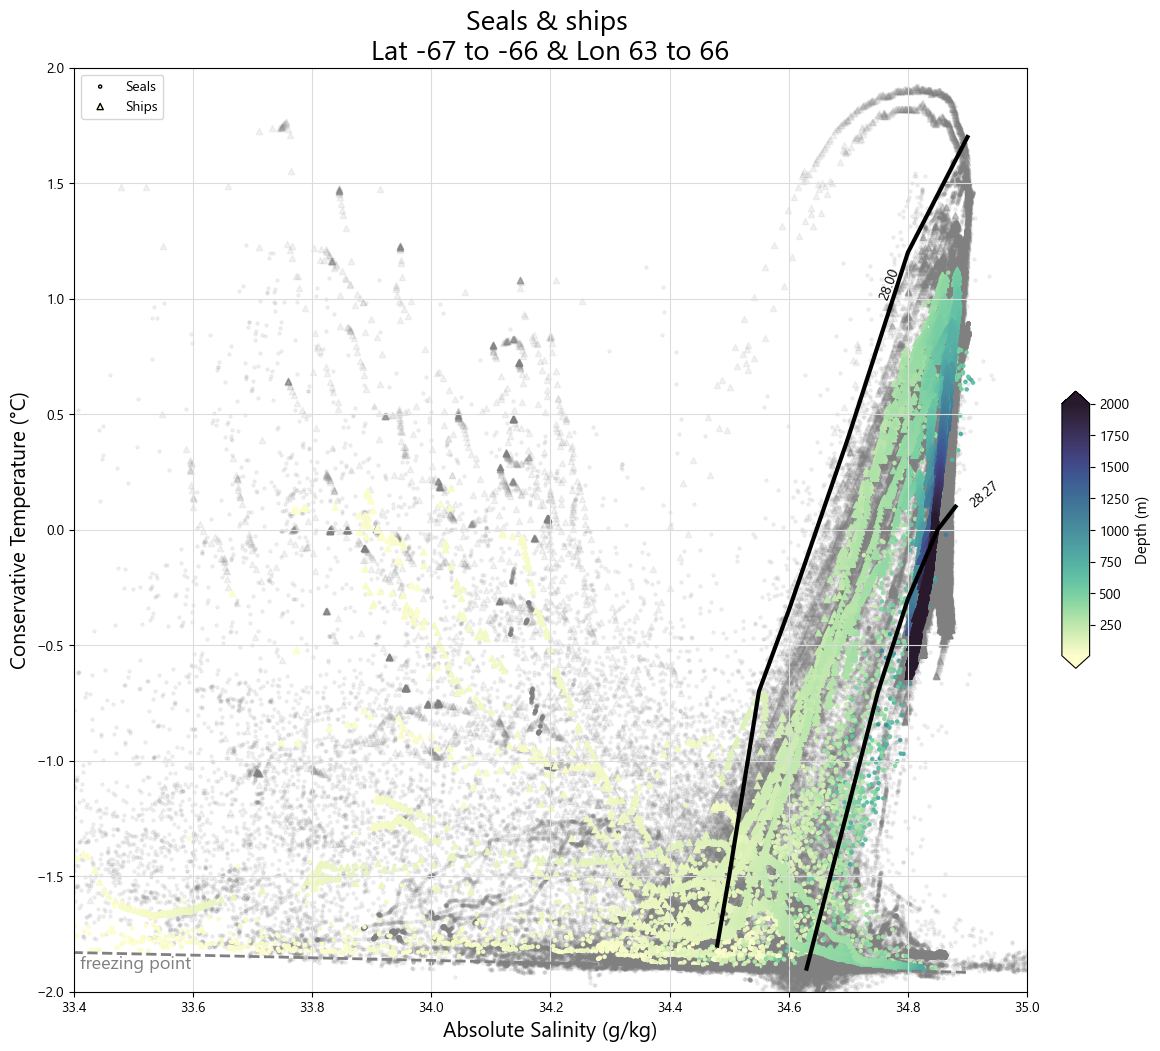

In [170]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
# #comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=2000, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=2000, marker='^', label='Ships')



# seals_scatter_in_range = plt.scatter(seals_abs_salinity, seals_cons_temperature,
#                            s=5, c=seals_depth, cmap=cmap_deep, vmax = 3000, marker='o', label='Seals')

# ships_scatter_in_range = plt.scatter(ships_abs_salinity, ships_cons_temperature,
#                            s=20, c=ships_depth, cmap=cmap_deep, vmax = 3000, marker='^', label='Ships')


#plot the x & y values from matlab to put on the neutral density lines    
# plt.plot(x, y, 'k', linewidth = '2.5')


##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.9,0.1,'28.27', rotation=40, fontsize=10)
plt.text(34.75,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Define the points for your contour line
contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_x1, contour_y1 = zip(*contour_points1)

# Plot the contour line
plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')


# Define the points for your contour line
contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_x2, contour_y2 = zip(*contour_points2)

# Plot the contour line
plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
plt.title(f'Seals & ships \nLat {lat_min} to {lat_max} & Lon {lon_min} to {lon_max}', fontsize=20)

plt.show()

In [9]:
#Then filter this data by season

# Define the time range you want to plot

# #Autumn
# time_min = 60
# time_max = 151

# #Winter
# time_min = 152
# time_max = 212

# #Spring
# time_min = 213
# time_max = 334

#summer 
time_min = 335
time_max = 59



# Filter the data based on latitude
#use this line for autumn, spring & winter
#indices_in_range = np.where((time >= time_min) & (time <= time_max))[0]
#use this line for summer
indices_in_range = np.where(((time >= 331) & (time <= 365)) | ((time >= 0) & (time <= 60)))[0]
season_cons_temperature_in_range = cons_temperature[indices_in_range]
season_abs_salinity_in_range = abs_salinity[indices_in_range]
season_depth_in_range = depth[indices_in_range]
season_filtered_latitude_in_range = latitude[indices_in_range]
season_filtered_longitude_in_range = longitude[indices_in_range]
season_filtered_neutral_density_in_range = neutral_density[indices_in_range]


#use this line for autumn, spring & winter
#indices_out_range = np.where((time < time_min) | (time > time_max))[0]
#use this line for summer
indices_out_range = np.where((time < 0) | ((time > 60) & (time < 331)) | (time > 365))[0]
season_cons_temperature_out_range = cons_temperature[indices_out_range]
season_abs_salinity_out_range = abs_salinity[indices_out_range]
season_depth_out_range = depth[indices_out_range]
season_filtered_latitude_out_range = latitude[indices_out_range]
season_filtered_longitude_out_range = longitude[indices_out_range]
season_filtered_neutral_density_out_range = neutral_density[indices_out_range]

len(season_filtered_longitude_in_range)

135090

<Figure size 640x480 with 0 Axes>

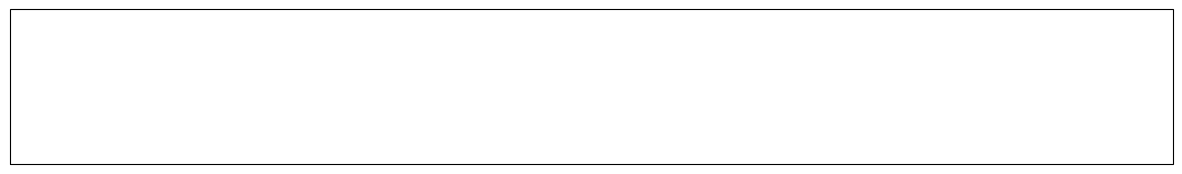

In [6]:
#This code extracts the contour at 600m along the shelf break and outputs it 
#had to manually make the lat lon bounds real close to it coz there was more than one conotur on the shelf at 600m,  then found the longest contour 
#couldn't do this with regular domain coz apparently one of the other ccontours was the longest and that's not the one i wanted

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import numpy as np
import matplotlib.pyplot as plt

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')

# Define the latitude and longitude extent of your figure
lon_min, lon_max, lat_min, lat_max = 63, 72, -67.2, -66

# Crop the GEBCO data to match the extent
gebco = gebco_full.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15, 10])
ax = None

# Make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

# Specify the desired contour level for the 600m isobath
desired_contour_level = -600

# Define the region where you want to contour (e.g., a bounding box)
# Change these coordinates to match the specific region of interest
lon_min = 63
lon_max = 72
lat_min = -67.2
lat_max = -66

# Extract contour segments within the specified region
contour_line = ax.contour(gebco.lon, gebco.lat, gebco.elevation, levels=[desired_contour_level], colors='white', linewidths=3, extent=(lon_min, lon_max, lat_min, lat_max))


# Initialize variables to store the longest contour line
max_length = 0
desired_contour_line = None

# Iterate through the contour lines to find the longest one
for contour_path in contour_line.collections:  # Use contour_line directly
    # Extract the vertices of the contour line
    vertices = contour_path.get_paths()[0].vertices  # Use contour_path directly
    
    # Calculate the length of the contour line
    path_length = np.sum(np.sqrt(np.diff(vertices[:, 0])**2 + np.diff(vertices[:, 1])**2))
    
    if path_length > max_length:
        max_length = path_length
        desired_contour_line = contour_path  # Store the contour_path, not contour_line

# Check if a contour line was found
if desired_contour_line is not None:
    # Extract the coordinates of the desired contour line
    contour_line_coordinates_shelf = desired_contour_line.get_paths()[0].vertices
    
    # Remove the original contours
    for contour_path in contour_line.collections:  # Use contour_line directly
        contour_path.remove()
    
    # Plot the desired contour line
    ax.plot(contour_line_coordinates_shelf[:, 0], contour_line_coordinates_shelf[:, 1], color='white', linewidth=3)
else:
    # Handle the case where no desired contour line was found
    print("No desired contour line found.")

<Figure size 640x480 with 0 Axes>

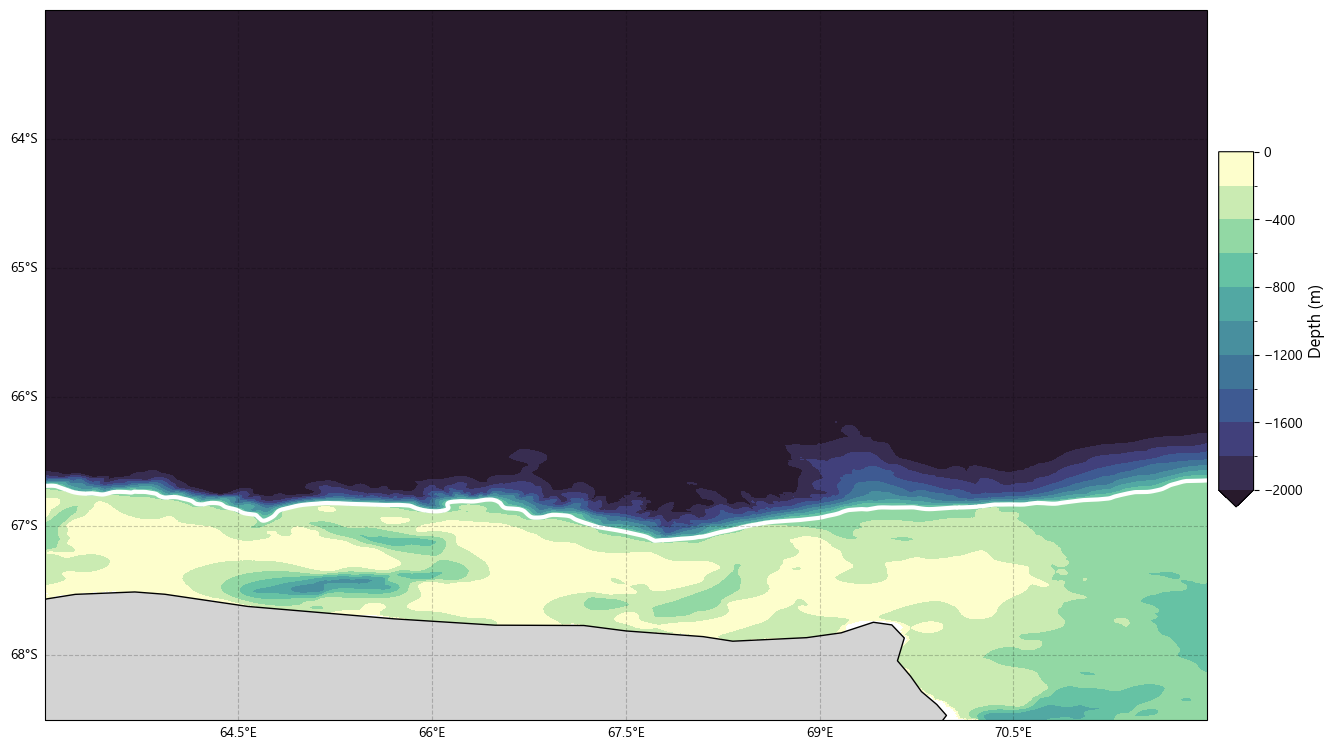

In [7]:
#This then plots the contour so you can visualise it 

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean


# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-2000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
ax.plot(contour_line_coordinates_shelf[:, 0], contour_line_coordinates_shelf[:, 1], color='white', linewidth=3)

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='right',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

In [8]:
#this creates the polygon with 3 straight lines and the one contour from above

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely.ops import unary_union

# print(contour_line_coordinates)

# Create the Shapely LineString from the contour points
contour_line = LineString(contour_line_coordinates_shelf)

# Find the starting and ending coordinates of the contour line
start_lon, start_lat = contour_line_coordinates_shelf[0]
end_lon, end_lat = contour_line_coordinates_shelf[-1]

# print(start_lon, end_lon)
# print(start_lat, end_lat)

# Create the other three sides of the polygon
side1 = LineString([(end_lon, end_lat), (end_lon, -68.5)])
side2 = LineString([(end_lon, -68.5), (start_lon, -68.5)])
side3 = LineString([(start_lon, -68.5),(start_lon, start_lat)])

# Create an empty Polygon
polygon_shelf = Polygon()


# Create a polygon by passing the combined coordinates to the Polygon constructor
polygon_shelf = Polygon(list(contour_line.coords) + list(side1.coords) + list(side2.coords) + list(side3.coords))


# output the polygon to series of xy values
x, y = polygon_shelf.exterior.xy

<Figure size 640x480 with 0 Axes>

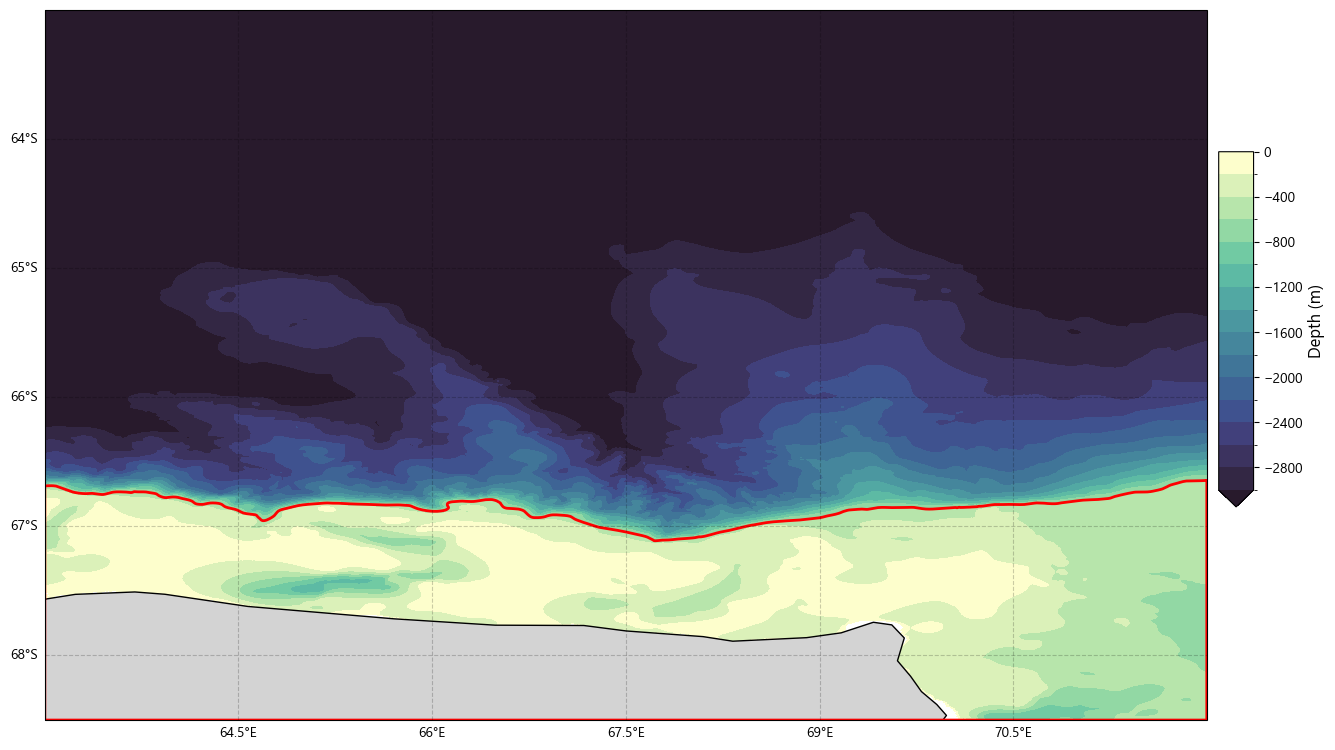

In [9]:
#This plots the polygon on the map to check it works

# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
#ax.plot(contour_line_coordinates[:, 0], contour_line_coordinates[:, 1], color='white', linewidth=3)

# # Plot the result using Matplotlib
# x, y = polygon.exterior.xy

# Plot the contour polygon
ax.plot(x, y, color='red', linewidth=2)

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='right',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

In [10]:
# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]


print(seals_longitude)
min(seals_longitude)

[68.27180267 68.27180267 68.27180267 ... 71.407      71.407
 71.407     ]


63.0258

In [124]:
#west
lon_min = 63
lon_max = 66.5

# #central
# lon_min = 66.5
# lon_max = 70

# #east
# lon_min = 70
# lon_max = 72
#note, make sure to comment out the ship in range calculations in the code below. There r no ship measurements and the code can't deal with that

In [125]:
#this crops the data with the shelf polygon and finds data inside, and outside of this polygon

from shapely.geometry import Polygon, Point
import numpy as np



# Initialize lists to store indices for data within and outside the polygon
seals_indices_in_range = []
seals_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(seals_latitude)):
    latitude = seals_latitude[i]
    longitude = seals_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_shelf.contains(point):
    #     seals_indices_in_range.append(i)
    # else:
    #     seals_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_shelf.contains(point) and lon_min <= longitude <= lon_max:
        seals_indices_in_range.append(i)
    else:
        seals_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
seals_indices_in_range = np.array(seals_indices_in_range)
seals_indices_out_range = np.array(seals_indices_out_range)

# Crop the data based on the indices
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_time[seals_indices_in_range]
seals_lat_in_range = seals_latitude[seals_indices_in_range]
seals_lon_in_range = seals_longitude[seals_indices_in_range]

seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_time[seals_indices_out_range]
seals_lat_out_range = seals_latitude[seals_indices_out_range]
seals_lon_out_range = seals_longitude[seals_indices_out_range]






# Initialize lists to store indices for data within and outside the polygon
ships_indices_in_range = []
ships_indices_out_range = []

for i in range(len(ships_latitude)):
    latitude = ships_latitude[i]
    longitude = ships_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_shelf.contains(point):
    #     ships_indices_in_range.append(i)
    # else:
    #     ships_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_shelf.contains(point) and lon_min <= longitude <= lon_max:
        ships_indices_in_range.append(i)
    else:
        ships_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
ships_indices_in_range = np.array(ships_indices_in_range)
ships_indices_out_range = np.array(ships_indices_out_range)

# Crop the data based on the indices
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_time[ships_indices_in_range]
ships_lat_in_range = ships_latitude[seals_indices_in_range]
ships_lon_in_range = ships_longitude[seals_indices_in_range]

ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_time[ships_indices_out_range]
ships_lat_in_range = ships_latitude[seals_indices_out_range]
ships_lon_in_range = ships_longitude[seals_indices_out_range]

<Figure size 640x480 with 0 Axes>

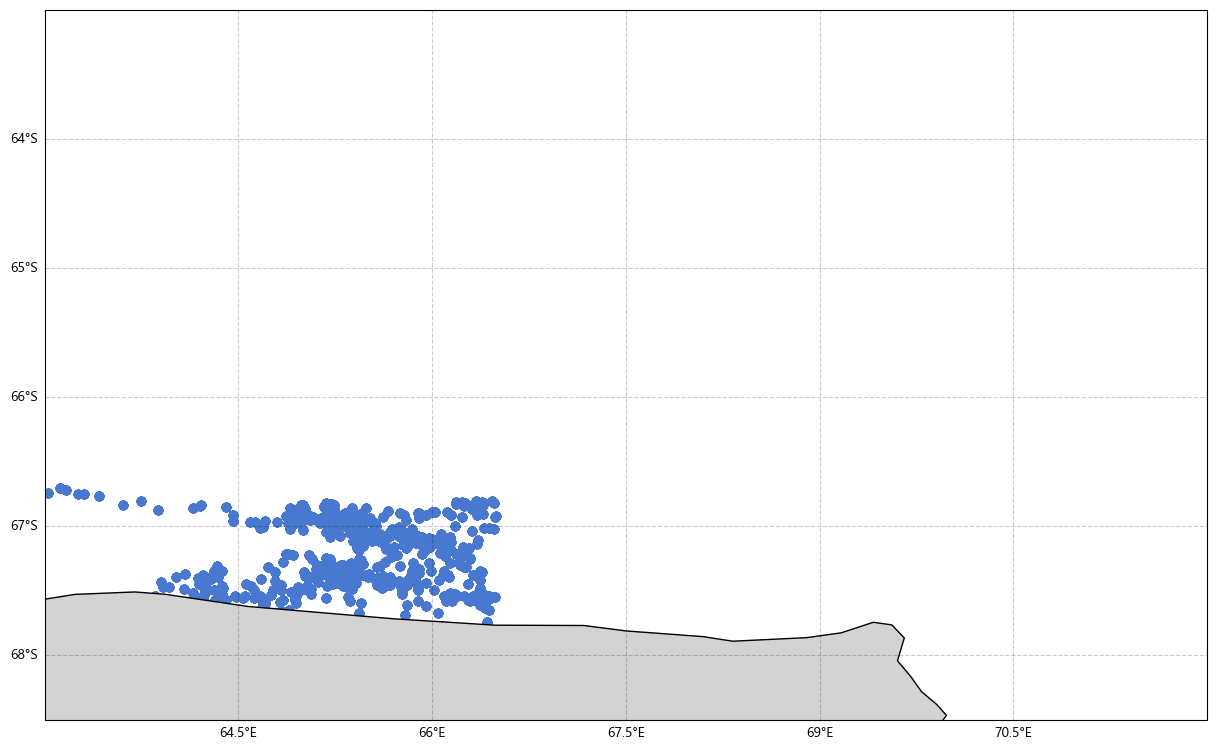

In [126]:
#Check the data has been cropped correctly

# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
#im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

plt.scatter(seals_lon_in_range, seals_lat_in_range)

# #add colourbar
# cax = inset_axes(ax,
#                 width="3%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='right',
#                 bbox_to_anchor=(.04,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\3268147110.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\3268147110.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\3268147110.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sien

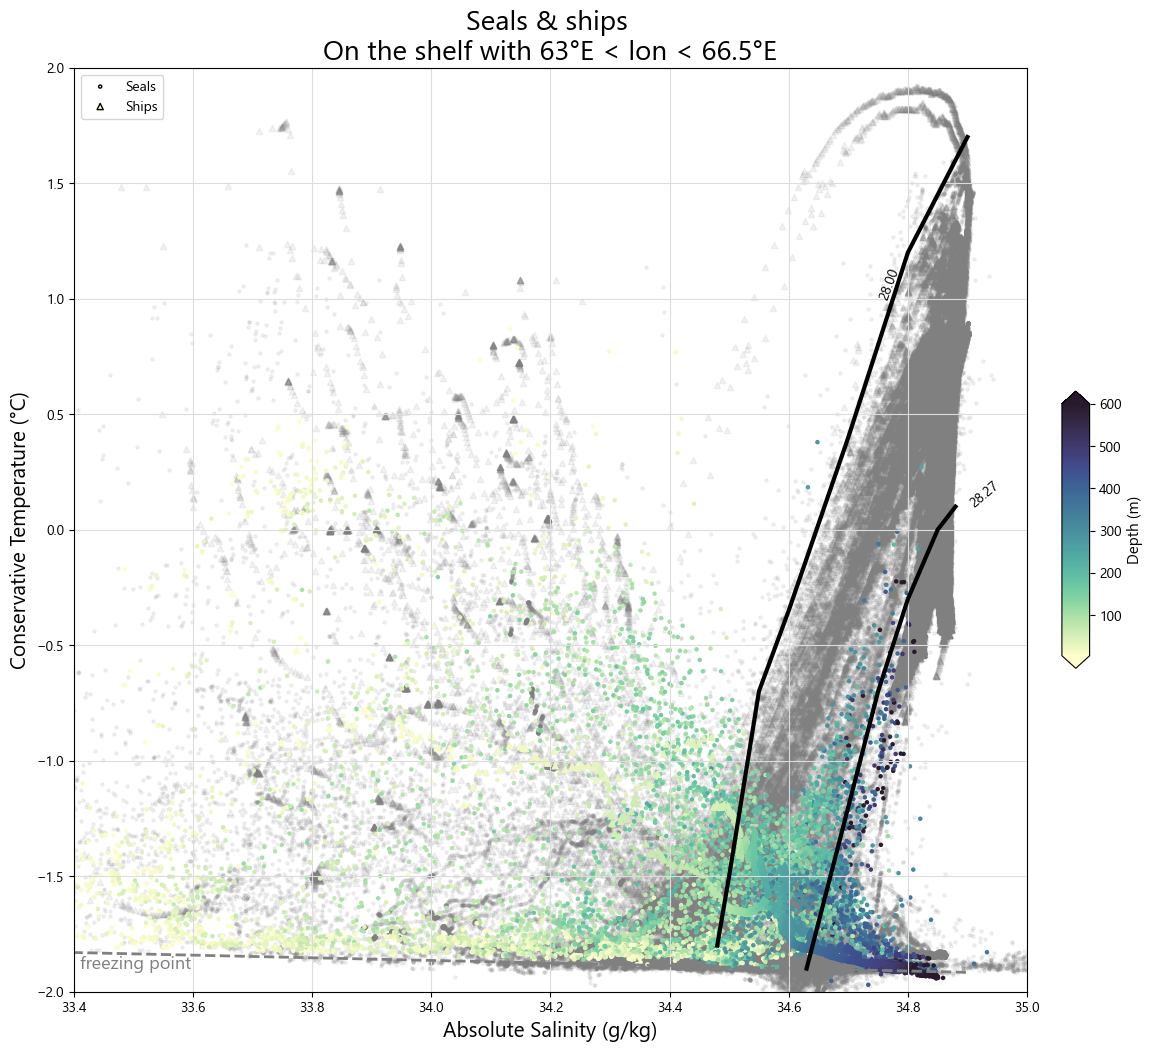

In [127]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
# #comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=600, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=600, marker='^', label='Ships')




##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.9,0.1,'28.27', rotation=40, fontsize=10)
plt.text(34.75,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Define the points for your contour line
contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_x1, contour_y1 = zip(*contour_points1)

# Plot the contour line
plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')


# Define the points for your contour line
contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_x2, contour_y2 = zip(*contour_points2)

# Plot the contour line
plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
#plt.title(f'Seals & ships \nLat {lat_min} to {lat_max} & Lon {lon_min} to {lon_max}', fontsize=20)
plt.title(f'Seals & ships \nOn the shelf with {lon_min}°E < lon < {lon_max}°E', fontsize=20)

plt.show()

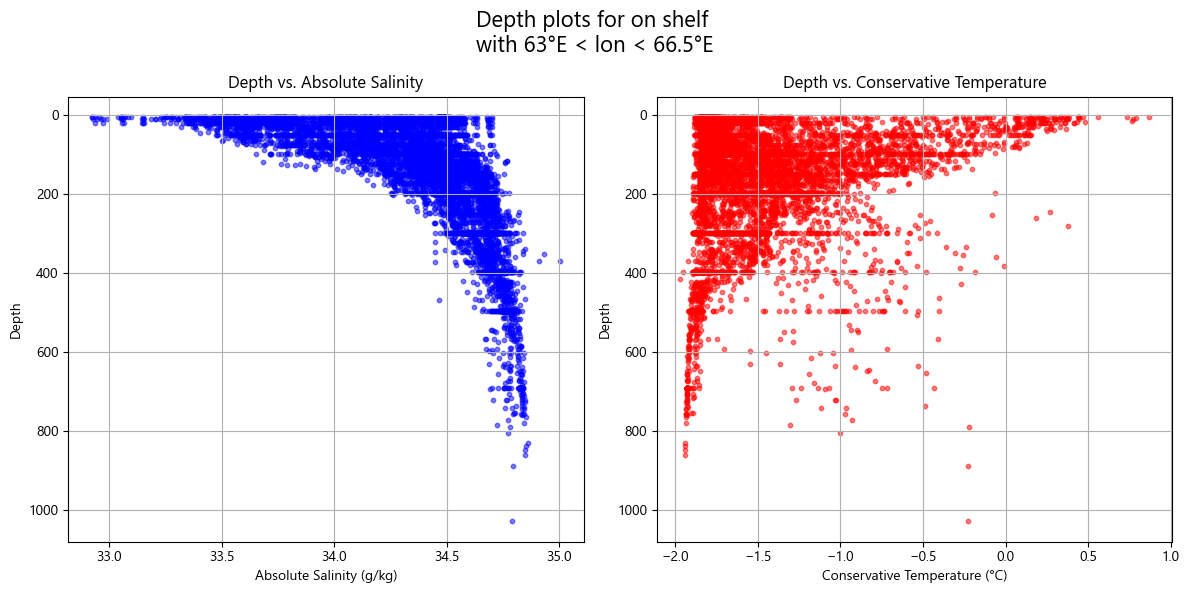

In [128]:
#depth vs variable plots for the section 

# Create a 1x2 subplot (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot Salinity vs. Depth on the left subplot (ax1)
ax1.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='blue', alpha=0.5, s=10)
ax1.set_xlabel('Absolute Salinity (g/kg)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Depth vs. Absolute Salinity')
ax1.grid(True)
ax1.invert_yaxis()  # Flip the y-axis

# Plot Temperature vs. Depth on the right subplot (ax2)
ax2.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.5, s=10)
ax2.set_xlabel('Conservative Temperature (°C)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Depth vs. Conservative Temperature')
ax2.grid(True)
ax2.invert_yaxis()  # Flip the y-axis

# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)


# Adjust spacing between subplots
plt.tight_layout()

plt.show()  # Display the subplot


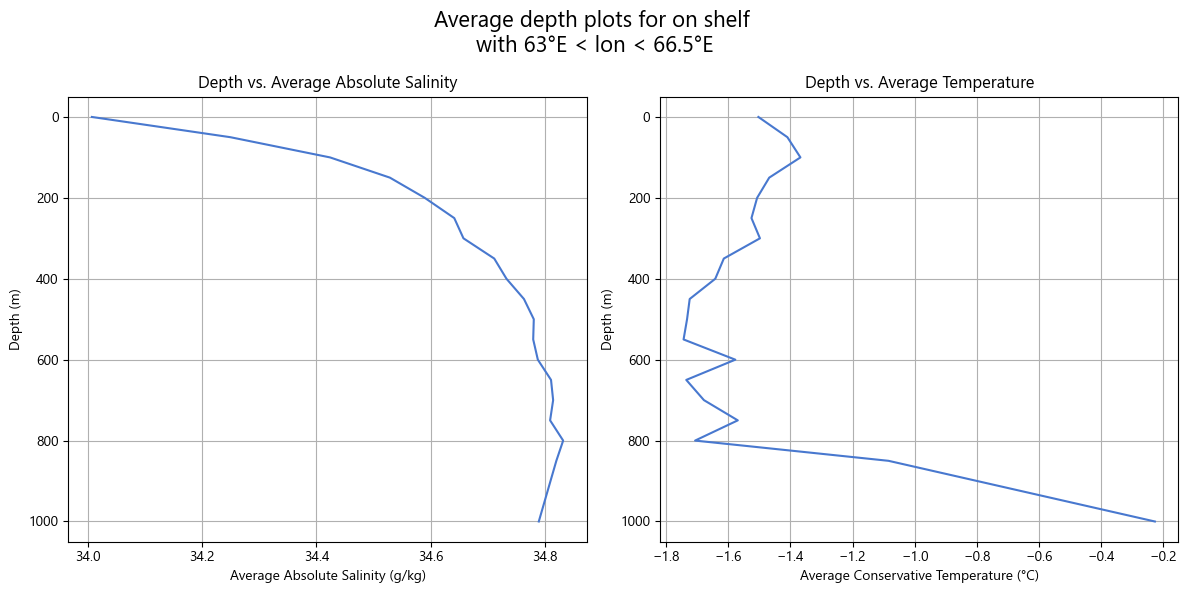

In [129]:
#calculate 50m average for cons temp & abs salt & plot
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from your data (assuming you have temperature data as well)
df = pd.DataFrame({
    'seals_depth_in_range': seals_depth_in_range,
    'seals_abs_salinity_in_range': seals_abs_salinity_in_range,
    'seals_cons_temperature_in_range': seals_cons_temperature_in_range  # Add temperature data here
})

# Round depth values to the nearest meter
df['depth_rounded'] = (df['seals_depth_in_range']//50)*50

# Group the data by the rounded depth and calculate the average absolute salinity and temperature
avg_abs_salinity_by_depth = df.groupby('depth_rounded')['seals_abs_salinity_in_range'].mean().reset_index()
avg_cons_temperature_by_depth = df.groupby('depth_rounded')['seals_cons_temperature_in_range'].mean().reset_index()


# Create a 1x2 subplot (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot the first subplot (Average Absolute Salinity vs. Depth)
ax1.plot(avg_abs_salinity_by_depth['seals_abs_salinity_in_range'], avg_abs_salinity_by_depth['depth_rounded'])
ax1.set_xlabel('Average Absolute Salinity (g/kg)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Depth vs. Average Absolute Salinity')
ax1.grid(True)
ax1.invert_yaxis()

# Plot the second subplot (Average Temperature vs. Depth)
ax2.plot(avg_cons_temperature_by_depth['seals_cons_temperature_in_range'], avg_cons_temperature_by_depth['depth_rounded'])
ax2.set_xlabel('Average Conservative Temperature (°C)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Depth vs. Average Temperature')
ax2.grid(True)
ax2.invert_yaxis()

# Add a large title that spans both subplots
fig.suptitle(f'Average depth plots for on shelf \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [100]:
# west
average_abs_salinity_shelf_west = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_shelf_west = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_shelf_west = avg_abs_salinity_by_depth['depth_rounded']

In [107]:
# central
average_abs_salinity_shelf_central = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_shelf_central = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_shelf_central = avg_abs_salinity_by_depth['depth_rounded']

In [115]:
# east
average_abs_salinity_shelf_east = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_shelf_east = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_shelf_east = avg_abs_salinity_by_depth['depth_rounded']

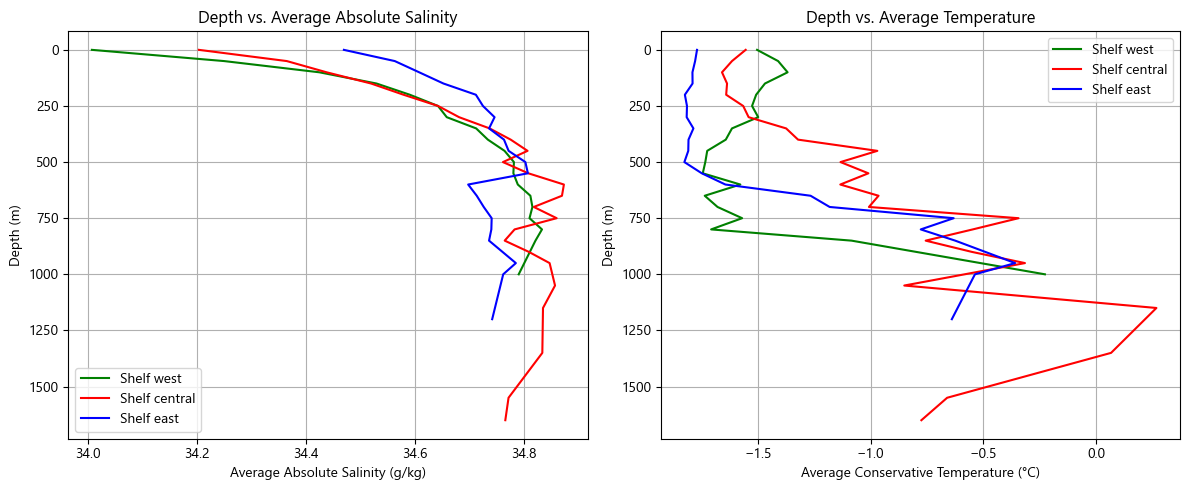

In [117]:
# Create a subplot with two side-by-side plots
plt.figure(figsize=(12, 5))

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 2, 1)
plt.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
plt.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
plt.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()

# Plot the second subplot (Average Temperature vs. Depth)
plt.subplot(1, 2, 2)
plt.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='green', label='Shelf west')
plt.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='red', label='Shelf central')
plt.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='blue', label='Shelf east')
plt.xlabel('Average Conservative Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Temperature')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

<Figure size 640x480 with 0 Axes>

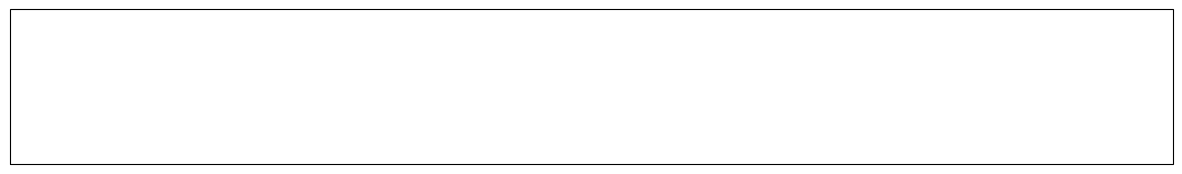

In [208]:
#This code extracts the contour at 2000m along the slope and outputs it 
#had to manually make the lat lon bounds real close to it coz there was more than one conotur on the shelf at 600m,  then found the longest contour 
#couldn't do this with regular domain coz apparently one of the other ccontours was the longest and that's not the one i wanted

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import numpy as np
import matplotlib.pyplot as plt

# Open the NetCDF file with xarray
gebco_full = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')

# Define the latitude and longitude extent of your figure
lon_min, lon_max, lat_min, lat_max = 63, 72, -67.2, -66

# Crop the GEBCO data to match the extent
gebco = gebco_full.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1, ncols=1, wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15, 10])
ax = None

# Make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

# Specify the desired contour level for the 600m isobath
desired_contour_level = -2000

# Define the region where you want to contour (e.g., a bounding box)
# Change these coordinates to match the specific region of interest
lon_min = 63
lon_max = 72
lat_min = -67.2
lat_max = -66

# Extract contour segments within the specified region
contour_line = ax.contour(gebco.lon, gebco.lat, gebco.elevation, levels=[desired_contour_level], colors='white', linewidths=3, extent=(lon_min, lon_max, lat_min, lat_max))


# Initialize variables to store the longest contour line
max_length = 0
desired_contour_line = None

# Iterate through the contour lines to find the longest one
for contour_path in contour_line.collections:  # Use contour_line directly
    # Extract the vertices of the contour line
    vertices = contour_path.get_paths()[0].vertices  # Use contour_path directly
    
    # Calculate the length of the contour line
    path_length = np.sum(np.sqrt(np.diff(vertices[:, 0])**2 + np.diff(vertices[:, 1])**2))
    
    if path_length > max_length:
        max_length = path_length
        desired_contour_line = contour_path  # Store the contour_path, not contour_line

# Check if a contour line was found
if desired_contour_line is not None:
    # Extract the coordinates of the desired contour line
    contour_line_coordinates_slope = desired_contour_line.get_paths()[0].vertices
    
    # Remove the original contours
    for contour_path in contour_line.collections:  # Use contour_line directly
        contour_path.remove()
    
    # Plot the desired contour line
    ax.plot(contour_line_coordinates_slope[:, 0], contour_line_coordinates_slope[:, 1], color='white', linewidth=3)
else:
    # Handle the case where no desired contour line was found
    print("No desired contour line found.")

<Figure size 640x480 with 0 Axes>

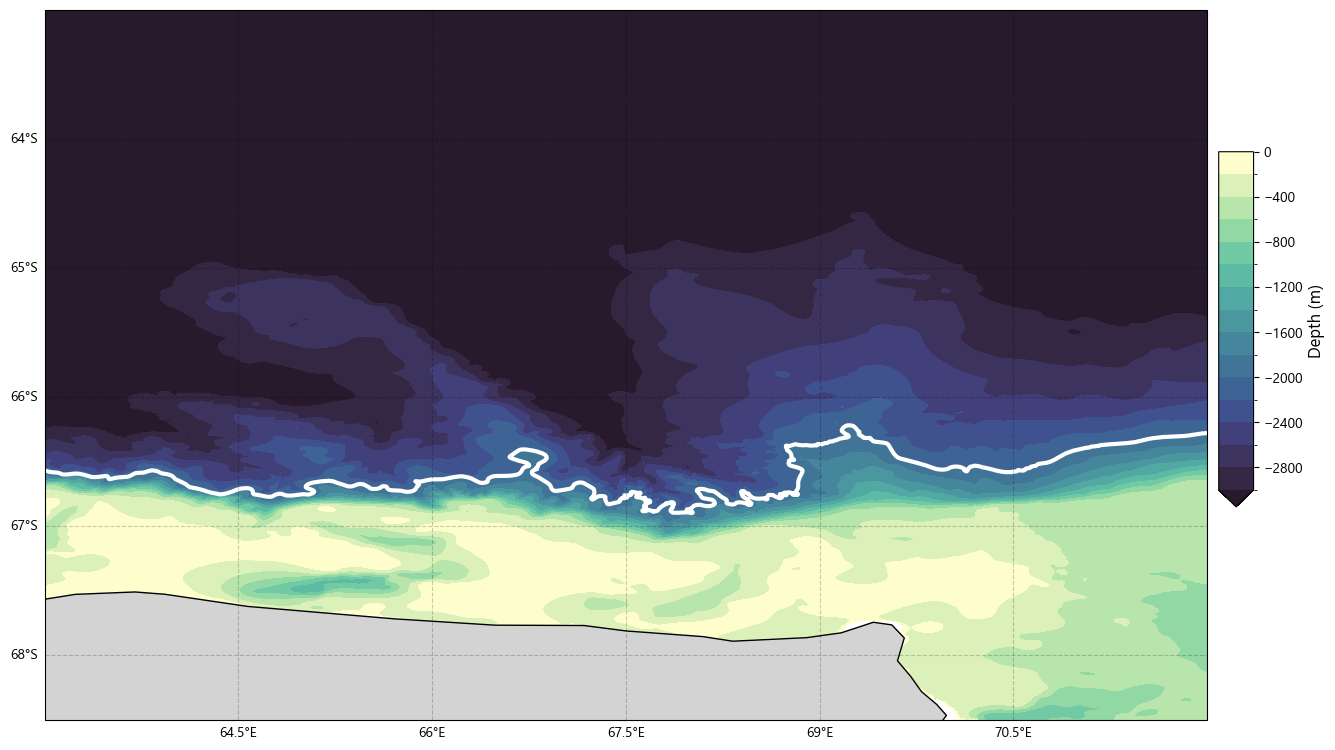

In [209]:
#This then plots the contour so you can visualise it 

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean


# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
ax.plot(contour_line_coordinates_slope[:, 0], contour_line_coordinates_slope[:, 1], color='white', linewidth=3)

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='right',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

In [210]:
#this creates the polygon with 2 straight lines, the one contour from above & the 600m contour

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely.ops import unary_union

# print(contour_line_coordinates)

# Create the Shapely LineString from the contour points
#Need to flip/reverse this contour line otherwise polygon doesn't work nicely 
reversed_coordinates = contour_line_coordinates_shelf[::-1]
# Create a new LineString with the reversed coordinates
contour_line_shelf = LineString(reversed_coordinates)
#this contour can stay as is
contour_line_slope = LineString(contour_line_coordinates_slope)

# Find the starting and ending coordinates of the contour line
start_lon_slope, start_lat_slope = contour_line_coordinates_slope[0]
end_lon_slope, end_lat_slope = contour_line_coordinates_slope[-1]


# Find the starting and ending coordinates of the contour line
start_lon_shelf, start_lat_shelf = contour_line_coordinates_shelf[0]
end_lon_shelf, end_lat_shelf = contour_line_coordinates_shelf[-1]



print(start_lon_slope, end_lon_slope)
print(start_lat_slope, end_lat_slope)

print(start_lon_shelf, end_lon_shelf)
print(start_lat_shelf, end_lat_shelf)


# Create the other three sides of the polygon
side1 = LineString([(end_lon_slope, end_lat_slope), (end_lon_shelf, end_lat_shelf)])
side2 = LineString([(start_lon_shelf, start_lat_shelf), (start_lon_slope, start_lat_slope)])

# Create an empty Polygon
polygon_slope = Polygon()


# Create a polygon by passing the combined coordinates to the Polygon constructor
polygon_slope = Polygon(list(contour_line_slope.coords) + list(side1.coords) + list(contour_line_shelf.coords) + list(side2.coords))


# output the polygon to series of xy values
x, y = polygon_slope.exterior.xy

71.99791666666667 63.00208333333333
-66.27800925925926 -66.56963383838384
71.99791666666667 63.00208333333333
-66.64486111111111 -66.68753531073446


<Figure size 640x480 with 0 Axes>

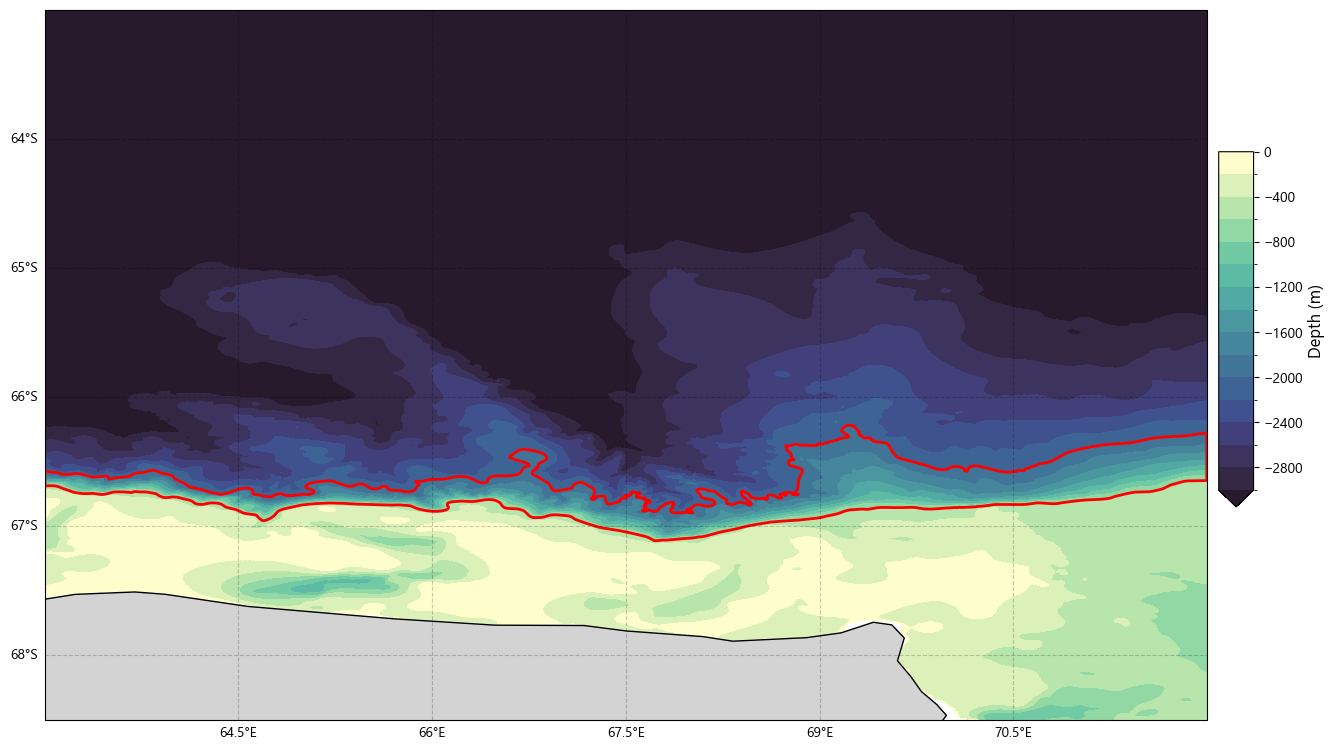

In [211]:
#This plots the polygon on the map to check it works

# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
#ax.plot(contour_line_coordinates[:, 0], contour_line_coordinates[:, 1], color='white', linewidth=3)

# # Plot the result using Matplotlib
# x, y = polygon.exterior.xy

# Plot the contour polygon
ax.plot(x, y, color='red', linewidth=2)

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='right',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

In [212]:
# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]


print(seals_longitude)
min(seals_longitude)

[68.27180267 68.27180267 68.27180267 ... 71.407      71.407
 71.407     ]


63.0258

In [213]:
# #west
# lon_min = 63
# lon_max = 66.5

# #central
# lon_min = 66.5
# lon_max = 70

#east
lon_min = 70
lon_max = 72

In [214]:
#this crops the data with the shelf polygon and finds data inside, and outside of this polygon

from shapely.geometry import Polygon, Point
import numpy as np



# Initialize lists to store indices for data within and outside the polygon
seals_indices_in_range = []
seals_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(seals_latitude)):
    latitude = seals_latitude[i]
    longitude = seals_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_slope.contains(point):
    #     seals_indices_in_range.append(i)
    # else:
    #     seals_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_slope.contains(point) and lon_min <= longitude <= lon_max:
        seals_indices_in_range.append(i)
    else:
        seals_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
seals_indices_in_range = np.array(seals_indices_in_range)
seals_indices_out_range = np.array(seals_indices_out_range)

# Crop the data based on the indices
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_time[seals_indices_in_range]
seals_lat_in_range = seals_latitude[seals_indices_in_range]
seals_lon_in_range = seals_longitude[seals_indices_in_range]

seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_time[seals_indices_out_range]
seals_lat_out_range = seals_latitude[seals_indices_out_range]
seals_lon_out_range = seals_longitude[seals_indices_out_range]






# Initialize lists to store indices for data within and outside the polygon
ships_indices_in_range = []
ships_indices_out_range = []

for i in range(len(ships_latitude)):
    latitude = ships_latitude[i]
    longitude = ships_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_slope.contains(point):
    #     ships_indices_in_range.append(i)
    # else:
    #     ships_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_slope.contains(point) and lon_min <= longitude <= lon_max:
        ships_indices_in_range.append(i)
    else:
        ships_indices_out_range.append(i)

# Convert the index lists to NumPy arrays for indexing
ships_indices_in_range = np.array(ships_indices_in_range)
ships_indices_out_range = np.array(ships_indices_out_range)

# Crop the data based on the indices
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_time[ships_indices_in_range]
ships_lat_in_range = ships_latitude[seals_indices_in_range]
ships_lon_in_range = ships_longitude[seals_indices_in_range]

ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_time[ships_indices_out_range]
ships_lat_in_range = ships_latitude[seals_indices_out_range]
ships_lon_in_range = ships_longitude[seals_indices_out_range]

<Figure size 640x480 with 0 Axes>

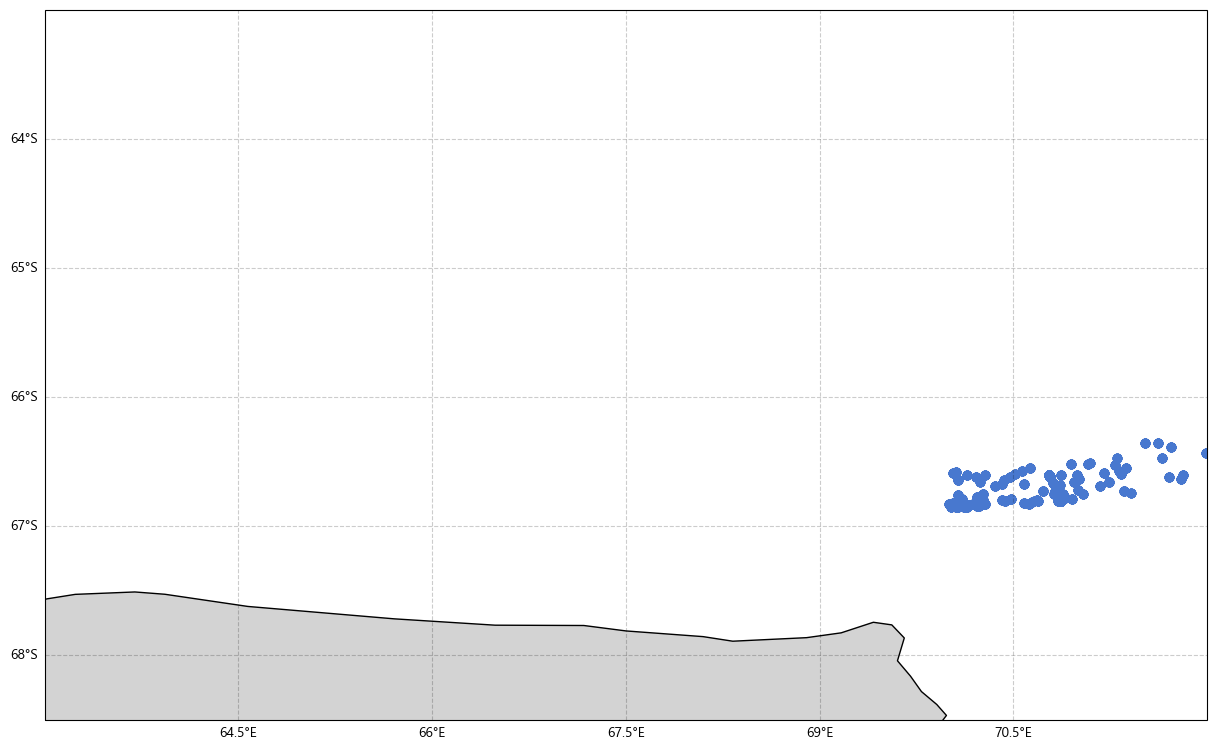

In [215]:
#Check the data has been cropped correctly

# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
#im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

plt.scatter(seals_lon_in_range, seals_lat_in_range)

# #add colourbar
# cax = inset_axes(ax,
#                 width="3%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='right',
#                 bbox_to_anchor=(.04,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\672756070.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\672756070.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\672756070.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sienn\A

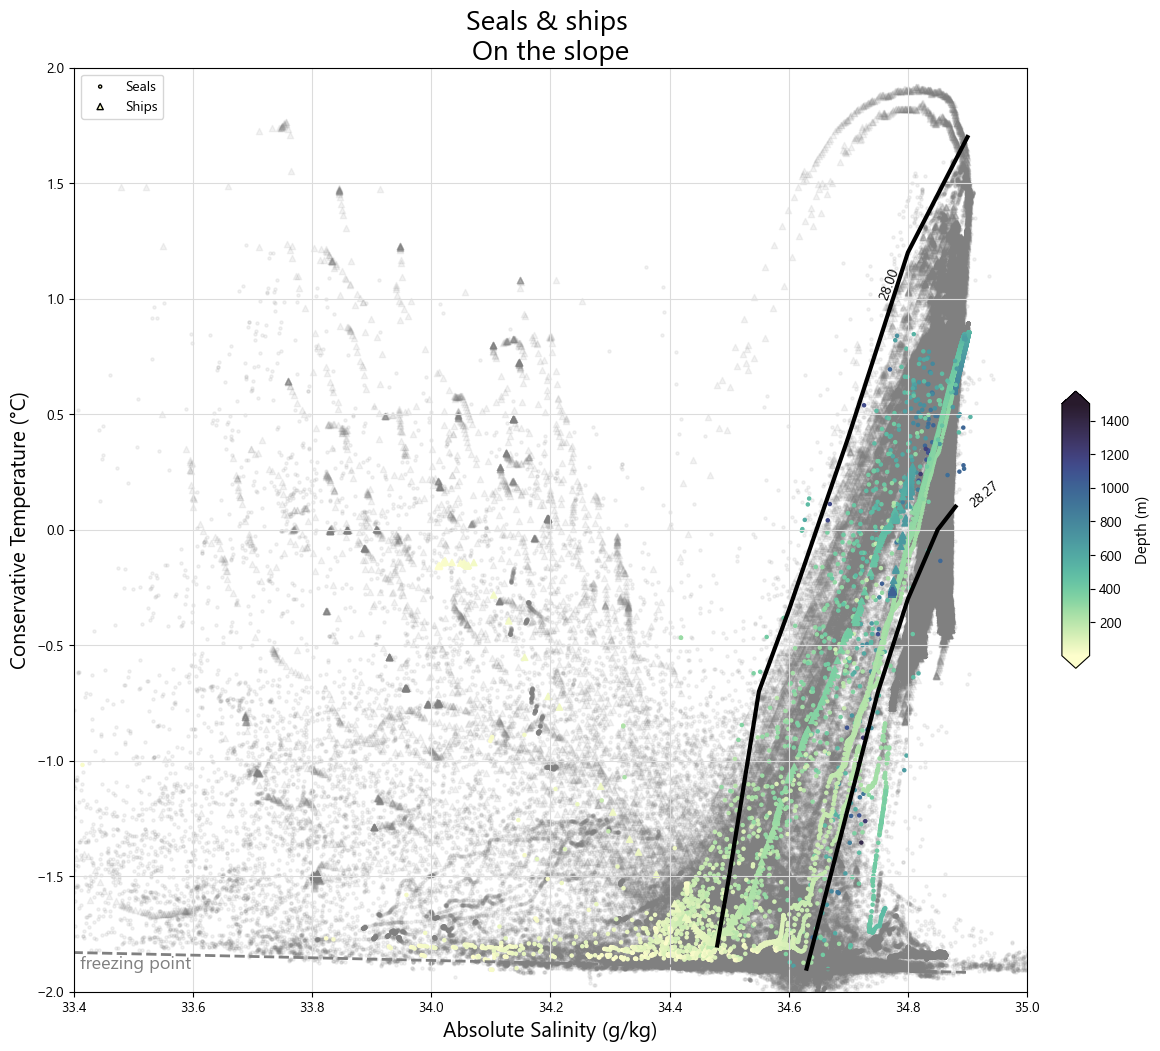

In [216]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
# #comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=1500, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=1500, marker='^', label='Ships')




##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.9,0.1,'28.27', rotation=40, fontsize=10)
plt.text(34.75,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Define the points for your contour line
contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_x1, contour_y1 = zip(*contour_points1)

# Plot the contour line
plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')


# Define the points for your contour line
contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_x2, contour_y2 = zip(*contour_points2)

# Plot the contour line
plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
#plt.title(f'Seals & ships \nLat {lat_min} to {lat_max} & Lon {lon_min} to {lon_max}', fontsize=20)
plt.title(f'Seals & ships \nOn the slope', fontsize=20)

plt.show()

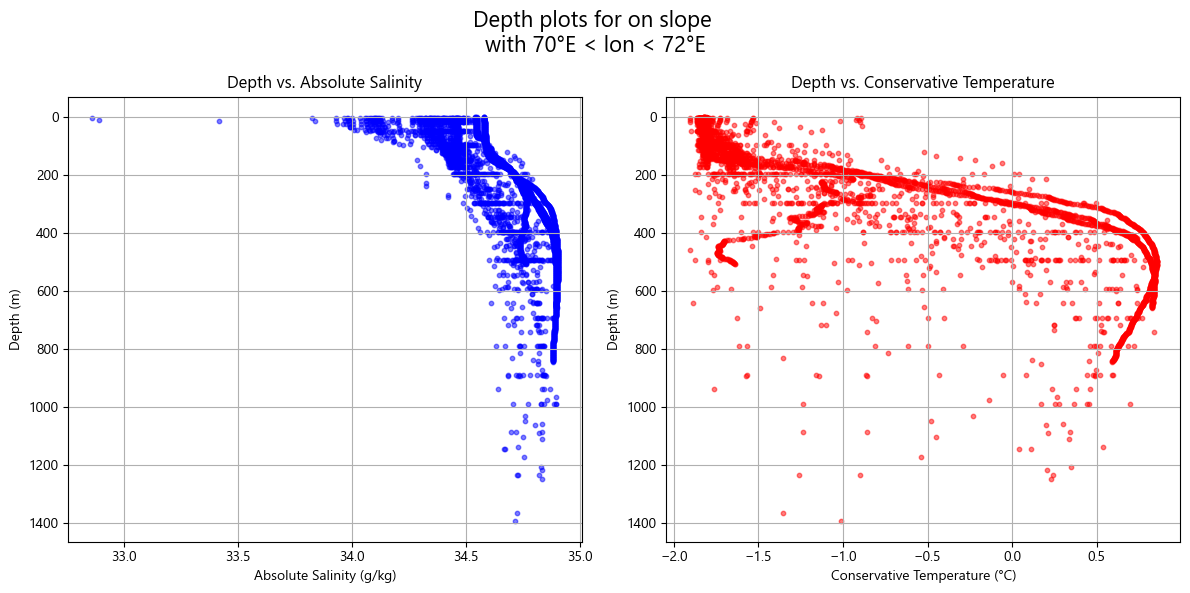

In [217]:
#depth vs variable plots for the section 

# Create a 1x2 subplot (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot Salinity vs. Depth on the left subplot (ax1)
ax1.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='blue', alpha=0.5, s=10)
ax1.set_xlabel('Absolute Salinity (g/kg)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Depth vs. Absolute Salinity')
ax1.grid(True)
ax1.invert_yaxis()  # Flip the y-axis

# Plot Temperature vs. Depth on the right subplot (ax2)
ax2.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.5, s=10)
ax2.set_xlabel('Conservative Temperature (°C)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Depth vs. Conservative Temperature')
ax2.grid(True)
ax2.invert_yaxis()  # Flip the y-axis

# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for on slope \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)


# Adjust spacing between subplots
plt.tight_layout()

plt.show()  # Display the subplot


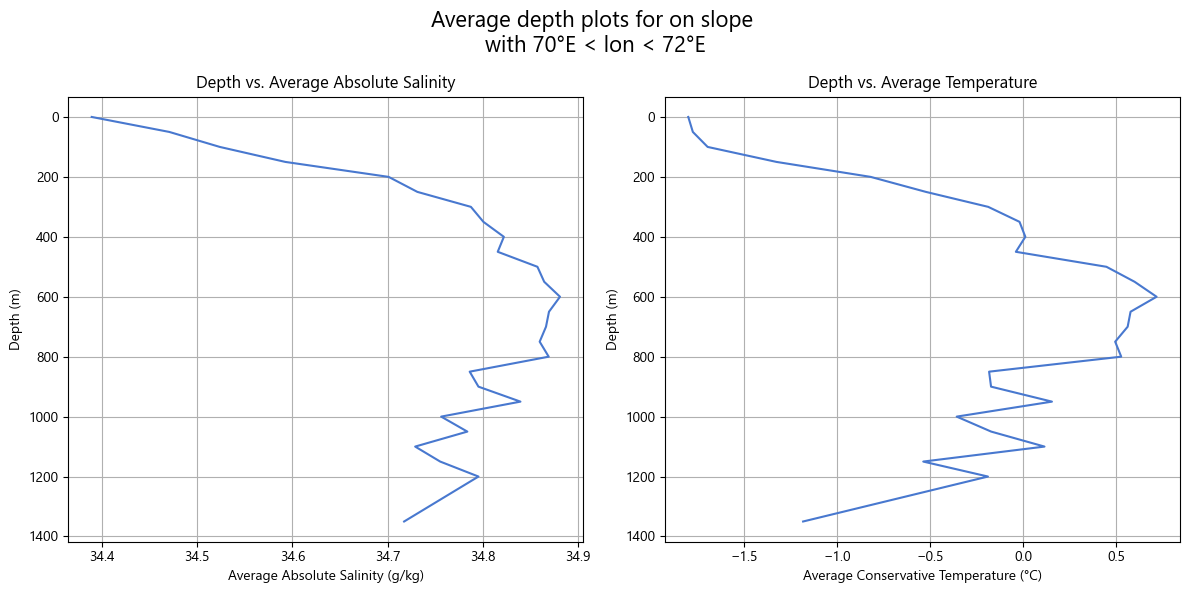

In [218]:
#calculate 50m average for cons temp & abs salt & plot
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from your data (assuming you have temperature data as well)
df = pd.DataFrame({
    'seals_depth_in_range': seals_depth_in_range,
    'seals_abs_salinity_in_range': seals_abs_salinity_in_range,
    'seals_cons_temperature_in_range': seals_cons_temperature_in_range  # Add temperature data here
})

# Round depth values to the nearest meter
df['depth_rounded'] = (df['seals_depth_in_range']//50)*50

# Group the data by the rounded depth and calculate the average absolute salinity and temperature
avg_abs_salinity_by_depth = df.groupby('depth_rounded')['seals_abs_salinity_in_range'].mean().reset_index()
avg_cons_temperature_by_depth = df.groupby('depth_rounded')['seals_cons_temperature_in_range'].mean().reset_index()


# Create a 1x2 subplot (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot the first subplot (Average Absolute Salinity vs. Depth)
ax1.plot(avg_abs_salinity_by_depth['seals_abs_salinity_in_range'], avg_abs_salinity_by_depth['depth_rounded'])
ax1.set_xlabel('Average Absolute Salinity (g/kg)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Depth vs. Average Absolute Salinity')
ax1.grid(True)
ax1.invert_yaxis()

# Plot the second subplot (Average Temperature vs. Depth)
ax2.plot(avg_cons_temperature_by_depth['seals_cons_temperature_in_range'], avg_cons_temperature_by_depth['depth_rounded'])
ax2.set_xlabel('Average Conservative Temperature (°C)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Depth vs. Average Temperature')
ax2.grid(True)
ax2.invert_yaxis()

# Add a large title that spans both subplots
fig.suptitle(f'Average depth plots for on slope \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [153]:
# west
average_abs_salinity_slope_west = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_slope_west = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_slope_west = avg_abs_salinity_by_depth['depth_rounded']

In [160]:
# central
average_abs_salinity_slope_central = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_slope_central = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_slope_central = avg_abs_salinity_by_depth['depth_rounded']

In [219]:
# east
average_abs_salinity_slope_east = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_slope_east = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_slope_east = avg_abs_salinity_by_depth['depth_rounded']

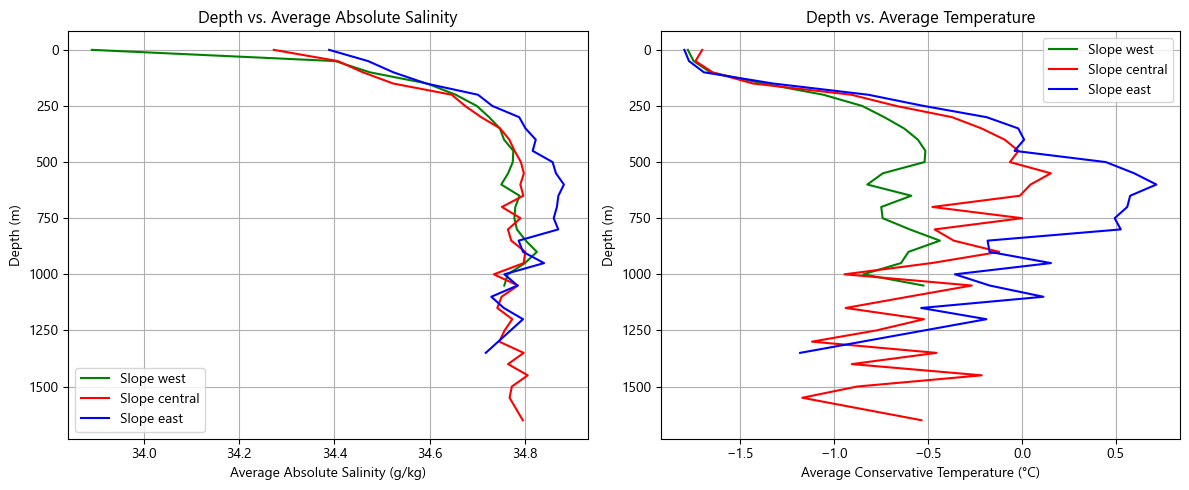

In [220]:
# Create a subplot with two side-by-side plots
plt.figure(figsize=(12, 5))

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 2, 1)
plt.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='green', label='Slope west')
plt.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='red', label='Slope central')
plt.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='blue', label='Slope east')
plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()

# Plot the second subplot (Average Temperature vs. Depth)
plt.subplot(1, 2, 2)
plt.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='green', label='Slope west')
plt.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='red', label='Slope central')
plt.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='blue', label='Slope east')
plt.xlabel('Average Conservative Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Temperature')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [175]:
#this creates the polygon with 3 straight lines and the one contour from above

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely.ops import unary_union

# print(contour_line_coordinates)

# Create the Shapely LineString from the contour points
contour_line_slope = LineString(contour_line_coordinates_slope)

# Find the starting and ending coordinates of the contour line
start_lon_slope, start_lat_slope = contour_line_coordinates_slope[0]
end_lon_slope, end_lat_slope = contour_line_coordinates_slope[-1]


print(start_lon_slope, end_lon_slope)
print(start_lat_slope, end_lat_slope)


# Create the other three sides of the polygon
side1 = LineString([(end_lon_slope, end_lat_slope), (end_lon_slope, -63)])
side2 = LineString([(end_lon_slope, -63), (start_lon_slope, -63)])
side3 = LineString([(start_lon_slope, -63), (start_lon_slope, start_lat_slope)])

# Create an empty Polygon
polygon_offshore = Polygon()


# Create a polygon by passing the combined coordinates to the Polygon constructor
polygon_offshore = Polygon(list(contour_line_slope.coords) + list(side1.coords) + list(side2.coords) + list(side3.coords))


# output the polygon to series of xy values
x, y = polygon_offshore.exterior.xy

71.99791666666667 63.00208333333333
-66.27800925925926 -66.56963383838384


<Figure size 640x480 with 0 Axes>

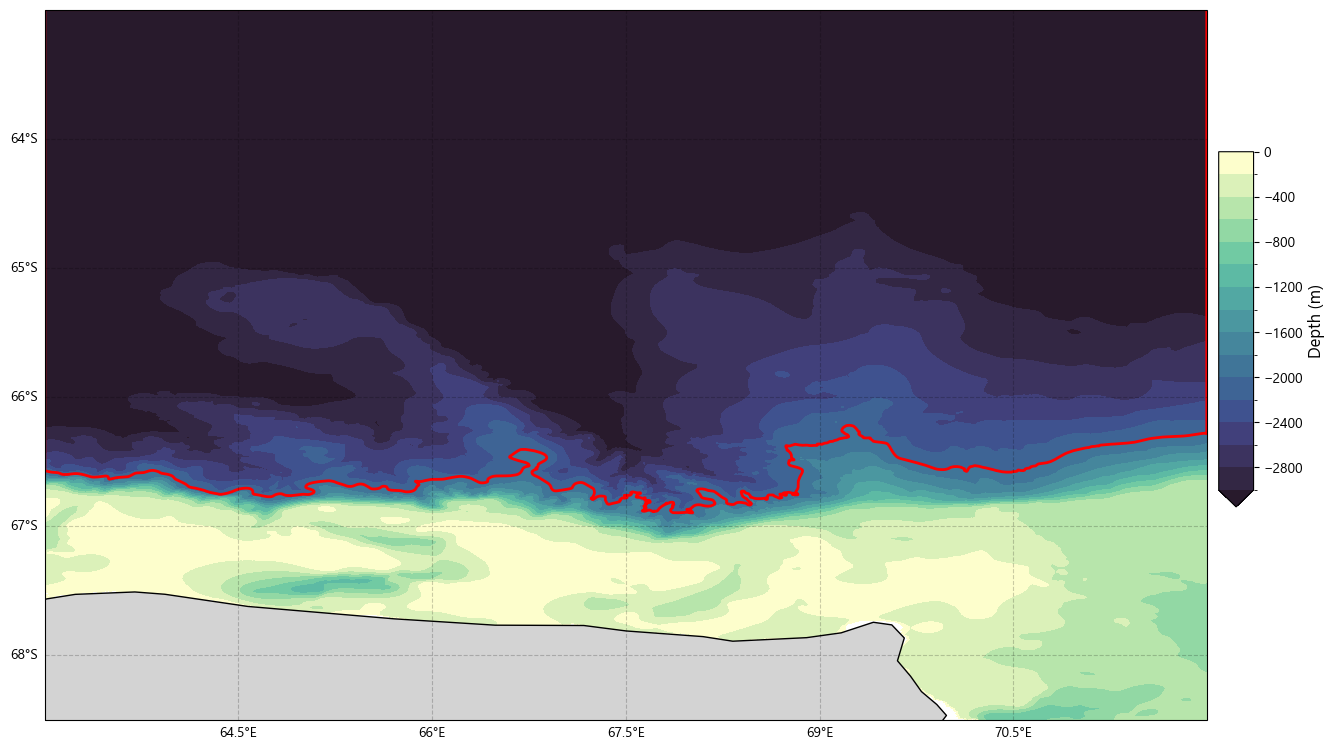

In [176]:
#This plots the polygon on the map to check it works

# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
#ax.plot(contour_line_coordinates[:, 0], contour_line_coordinates[:, 1], color='white', linewidth=3)

# # Plot the result using Matplotlib
# x, y = polygon.exterior.xy

# Plot the contour polygon
ax.plot(x, y, color='red', linewidth=2)

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='right',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

In [177]:
# Filter the data for seals and ships separately
seals_data = type == 1
ships_data = type == 2

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_temperature = temperature[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_salinity = salinity[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_temperature = temperature[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_salinity = salinity[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]


print(seals_longitude)
min(seals_longitude)

[68.27180267 68.27180267 68.27180267 ... 71.407      71.407
 71.407     ]


63.0258

In [193]:
# #west
# lon_min = 63
# lon_max = 66.5

# #central
# lon_min = 66.5
# lon_max = 70

#east
lon_min = 70
lon_max = 72

In [194]:
#this crops the data with the shelf polygon and finds data inside, and outside of this polygon

from shapely.geometry import Polygon, Point
import numpy as np



# Initialize lists to store indices for data within and outside the polygon
seals_indices_in_range = []
seals_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(seals_latitude)):
    latitude = seals_latitude[i]
    longitude = seals_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_offshore.contains(point):
    #     seals_indices_in_range.append(i)
    # else:
    #     seals_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_offshore.contains(point) and lon_min <= longitude <= lon_max:
        seals_indices_in_range.append(i)
    else:
        seals_indices_out_range.append(i)




# Convert the index lists to NumPy arrays for indexing
seals_indices_in_range = np.array(seals_indices_in_range)
seals_indices_out_range = np.array(seals_indices_out_range)

# Crop the data based on the indices
seals_cons_temperature_in_range = seals_cons_temperature[seals_indices_in_range]
seals_abs_salinity_in_range = seals_abs_salinity[seals_indices_in_range]
seals_depth_in_range = seals_depth[seals_indices_in_range]
seals_neutral_density_in_range = seals_neutral_density[seals_indices_in_range]
seals_time_in_range = seals_time[seals_indices_in_range]
seals_lat_in_range = seals_latitude[seals_indices_in_range]
seals_lon_in_range = seals_longitude[seals_indices_in_range]

seals_cons_temperature_out_range = seals_cons_temperature[seals_indices_out_range]
seals_abs_salinity_out_range = seals_abs_salinity[seals_indices_out_range]
seals_depth_out_range = seals_depth[seals_indices_out_range]
seals_neutral_density_out_range = seals_neutral_density[seals_indices_out_range]
seals_time_out_range = seals_time[seals_indices_out_range]
seals_lat_out_range = seals_latitude[seals_indices_out_range]
seals_lon_out_range = seals_longitude[seals_indices_out_range]






# Initialize lists to store indices for data within and outside the polygon
ships_indices_in_range = []
ships_indices_out_range = []

# Loop through your data points (assuming latitude and longitude are numpy arrays)
for i in range(len(ships_latitude)):
    latitude = ships_latitude[i]
    longitude = ships_longitude[i]
    point = Point(longitude, latitude)
    
    # # Check if the point is within the polygon (use this if you just want on shelf, slope & offshore)
    # if polygon_offshore.contains(point):
    #     ships_indices_in_range.append(i)
    # else:
    #     ships_indices_out_range.append(i)
    
    
    # Check if the point is within the polygon and longitude is within the specified range
    if polygon_offshore.contains(point) and lon_min <= longitude <= lon_max:
        ships_indices_in_range.append(i)
    else:
        ships_indices_out_range.append(i)


# Convert the index lists to NumPy arrays for indexing
ships_indices_in_range = np.array(ships_indices_in_range)
ships_indices_out_range = np.array(ships_indices_out_range)

# Crop the data based on the indices
ships_cons_temperature_in_range = ships_cons_temperature[ships_indices_in_range]
ships_abs_salinity_in_range = ships_abs_salinity[ships_indices_in_range]
ships_depth_in_range = ships_depth[ships_indices_in_range]
ships_neutral_density_in_range = ships_neutral_density[ships_indices_in_range]
ships_time_in_range = ships_time[ships_indices_in_range]
ships_lat_in_range = ships_latitude[seals_indices_in_range]
ships_lon_in_range = ships_longitude[seals_indices_in_range]

ships_cons_temperature_out_range = ships_cons_temperature[ships_indices_out_range]
ships_abs_salinity_out_range = ships_abs_salinity[ships_indices_out_range]
ships_depth_out_range = ships_depth[ships_indices_out_range]
ships_neutral_density_out_range = ships_neutral_density[ships_indices_out_range]
ships_time_out_range = ships_time[ships_indices_out_range]
ships_lat_in_range = ships_latitude[seals_indices_out_range]
ships_lon_in_range = ships_longitude[seals_indices_out_range]



<Figure size 640x480 with 0 Axes>

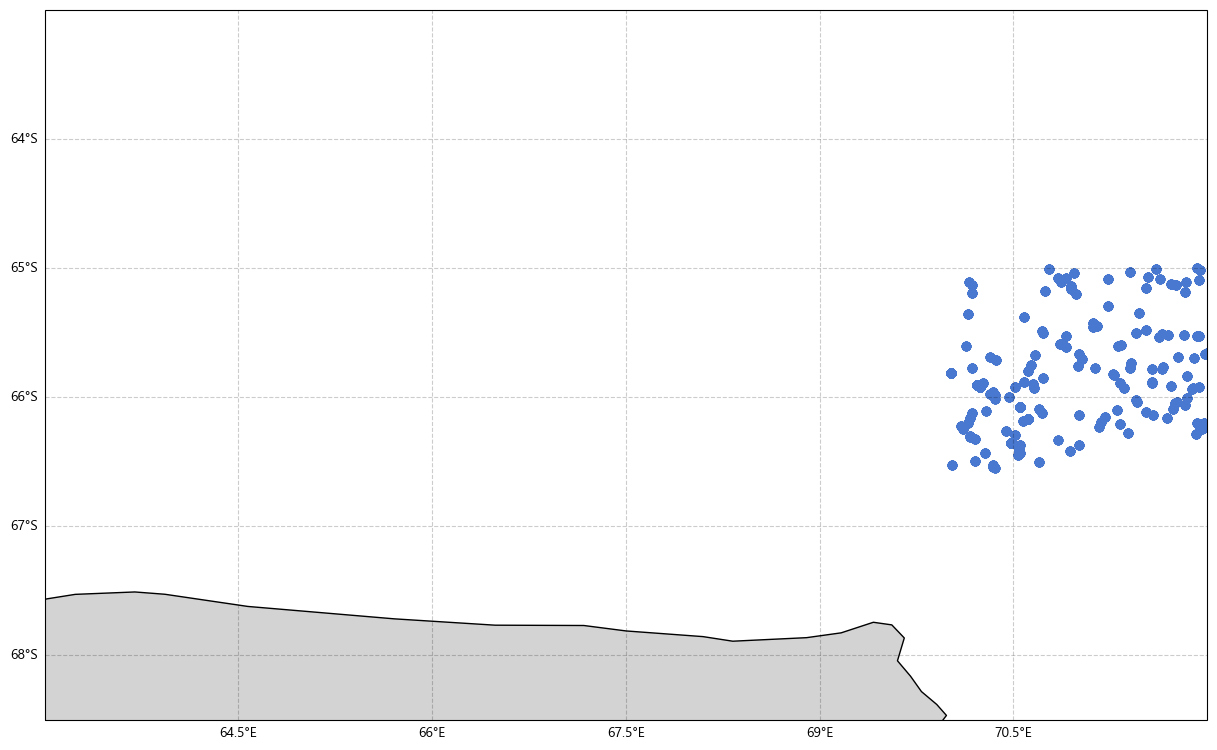

In [195]:
#Check the data has been cropped correctly

# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
#im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3000,200,200)]),add_colorbar=False)

plt.scatter(seals_lon_in_range, seals_lat_in_range)

# #add colourbar
# cax = inset_axes(ax,
#                 width="3%",  # width = 10% of parent_bbox width
#                 height="50%",  # height : 50%
#                 loc='right',
#                 bbox_to_anchor=(.04,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()

C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\345314033.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_temp = plt.cm.get_cmap('cmo.thermal')
C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\345314033.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_salt = plt.cm.get_cmap('cmo.haline')
C:\Users\sienn\AppData\Local\Temp\ipykernel_28540\345314033.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_dens = plt.cm.get_cmap('cmo.dense')
C:\Users\sienn\A

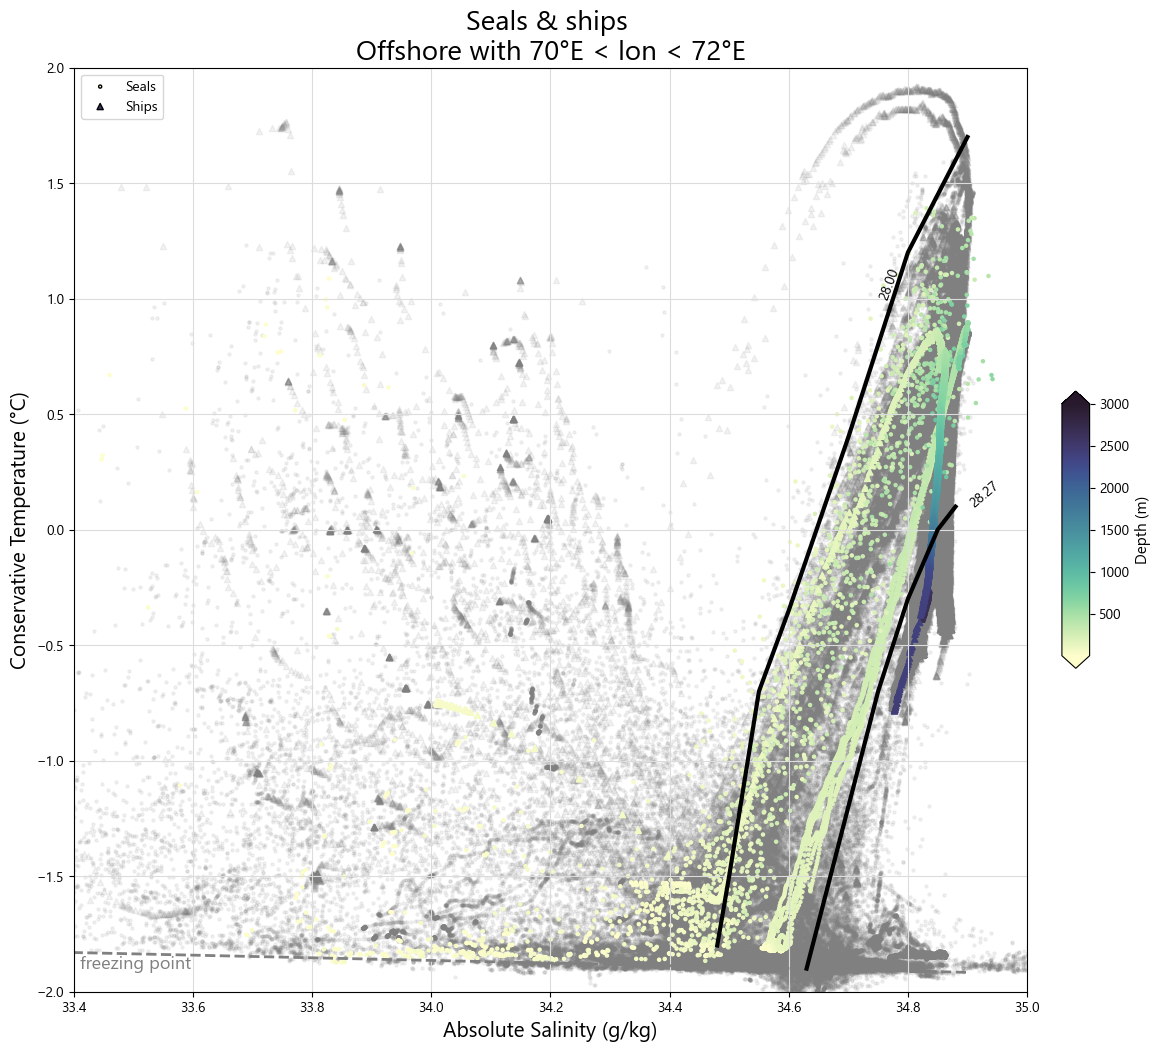

In [196]:
########################################################################################################################
####################################################plotting############################################################
########################################################################################################################

##just csv rn with colourbar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seawater
import gsw
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import rasterio.plot
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Calculate the potential density lines
sa = np.arange(33, 35, .1)
# #comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t


#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']


#set the size of the figure
plt.figure(figsize=(15, 12)) 


cmap_temp = plt.cm.get_cmap('cmo.thermal')
cmap_salt = plt.cm.get_cmap('cmo.haline')
cmap_dens = plt.cm.get_cmap('cmo.dense')
cmap_deep = plt.cm.get_cmap('cmo.deep')

# Define custom color boundaries
vmin1 = 27
vmax2 = 28
vmax3 = 28.27
vmax4 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin1, vmax2, vmax3, vmax4], cmap_custom.N)





# # Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter_out_range = plt.scatter(seals_abs_salinity_out_range, seals_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=5, marker='o')

ships_scatter_out_range = plt.scatter(ships_abs_salinity_out_range, ships_cons_temperature_out_range,
                           color='gray', alpha=0.1, s=20, marker='^')


seals_scatter_in_range = plt.scatter(seals_abs_salinity_in_range, seals_cons_temperature_in_range,
                           s=5, c=seals_depth_in_range, cmap=cmap_deep, vmax=3000, marker='o', label='Seals')

ships_scatter_in_range = plt.scatter(ships_abs_salinity_in_range, ships_cons_temperature_in_range,
                           s=20, c=ships_depth_in_range, cmap=cmap_deep, vmax=3000, marker='^', label='Ships')




##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)
#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.9,0.1,'28.27', rotation=40, fontsize=10)
plt.text(34.75,1,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

#Plot the potential density contour lines
# comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter_in_range, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Define the points for your contour line
contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_x1, contour_y1 = zip(*contour_points1)

# Plot the contour line
plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')


# Define the points for your contour line
contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_x2, contour_y2 = zip(*contour_points2)

# Plot the contour line
plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')

# Add a dynamic title
#plt.title(f'Seals & ships \nLat {lat_min} to {lat_max} & Lon {lon_min} to {lon_max}', fontsize=20)
plt.title(f'Seals & ships \nOffshore with {lon_min}°E < lon < {lon_max}°E', fontsize=20)

plt.show()

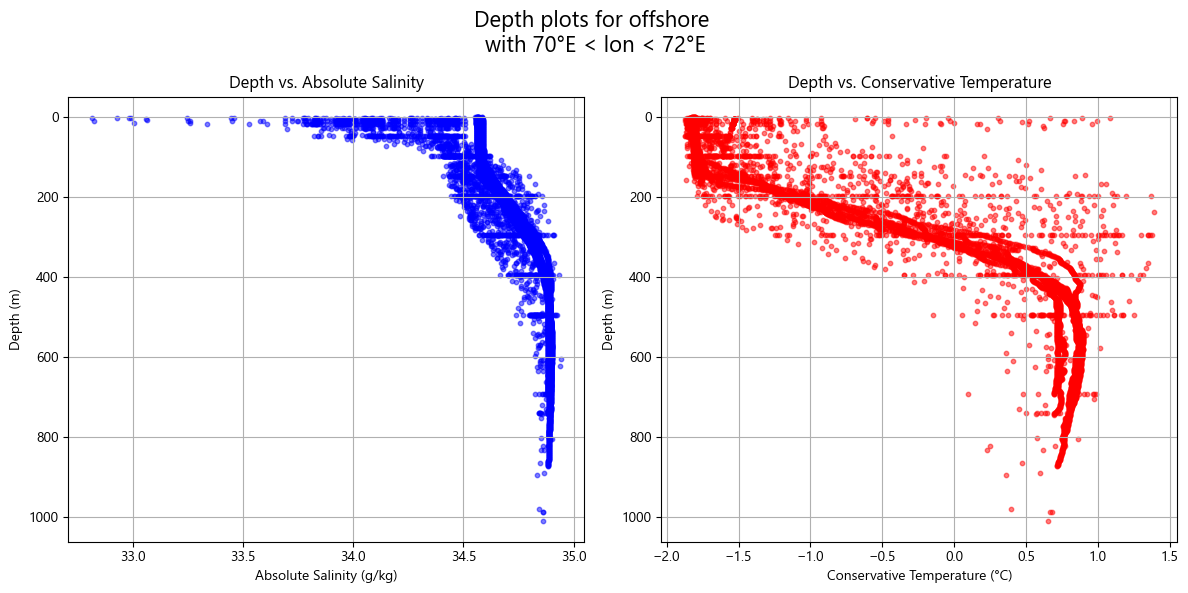

In [197]:
#depth vs variable plots for the section 

# Create a 1x2 subplot (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot Salinity vs. Depth on the left subplot (ax1)
ax1.scatter(seals_abs_salinity_in_range, seals_depth_in_range, c='blue', alpha=0.5, s=10)
ax1.set_xlabel('Absolute Salinity (g/kg)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Depth vs. Absolute Salinity')
ax1.grid(True)
ax1.invert_yaxis()  # Flip the y-axis

# Plot Temperature vs. Depth on the right subplot (ax2)
ax2.scatter(seals_cons_temperature_in_range, seals_depth_in_range, c='red', alpha=0.5, s=10)
ax2.set_xlabel('Conservative Temperature (°C)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Depth vs. Conservative Temperature')
ax2.grid(True)
ax2.invert_yaxis()  # Flip the y-axis

# Add a large title that spans both subplots
fig.suptitle(f'Depth plots for offshore \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)


# Adjust spacing between subplots
plt.tight_layout()

plt.show()  # Display the subplot


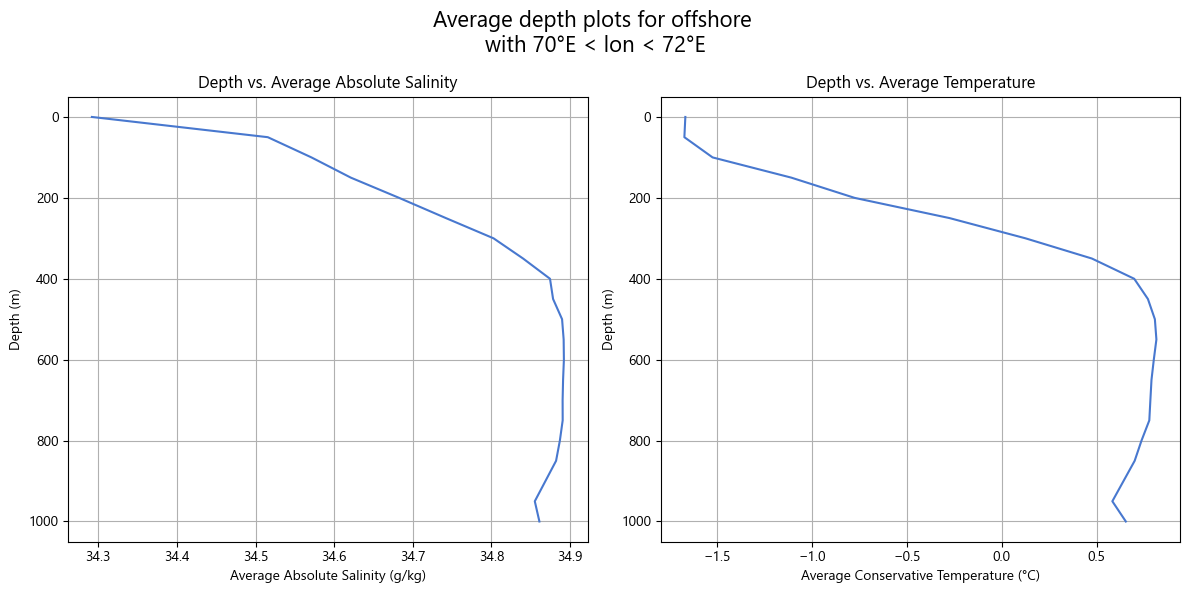

In [198]:
#calculate 50m average for cons temp & abs salt & plot
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from your data (assuming you have temperature data as well)
df = pd.DataFrame({
    'seals_depth_in_range': seals_depth_in_range,
    'seals_abs_salinity_in_range': seals_abs_salinity_in_range,
    'seals_cons_temperature_in_range': seals_cons_temperature_in_range  # Add temperature data here
})

# Round depth values to the nearest meter
df['depth_rounded'] = (df['seals_depth_in_range']//50)*50

# Group the data by the rounded depth and calculate the average absolute salinity and temperature
avg_abs_salinity_by_depth = df.groupby('depth_rounded')['seals_abs_salinity_in_range'].mean().reset_index()
avg_cons_temperature_by_depth = df.groupby('depth_rounded')['seals_cons_temperature_in_range'].mean().reset_index()


# Create a 1x2 subplot (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figure size as needed

# Plot the first subplot (Average Absolute Salinity vs. Depth)
ax1.plot(avg_abs_salinity_by_depth['seals_abs_salinity_in_range'], avg_abs_salinity_by_depth['depth_rounded'])
ax1.set_xlabel('Average Absolute Salinity (g/kg)')
ax1.set_ylabel('Depth (m)')
ax1.set_title('Depth vs. Average Absolute Salinity')
ax1.grid(True)
ax1.invert_yaxis()

# Plot the second subplot (Average Temperature vs. Depth)
ax2.plot(avg_cons_temperature_by_depth['seals_cons_temperature_in_range'], avg_cons_temperature_by_depth['depth_rounded'])
ax2.set_xlabel('Average Conservative Temperature (°C)')
ax2.set_ylabel('Depth (m)')
ax2.set_title('Depth vs. Average Temperature')
ax2.grid(True)
ax2.invert_yaxis()

# Add a large title that spans both subplots
fig.suptitle(f'Average depth plots for offshore \nwith {lon_min}°E < lon < {lon_max}°E', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [185]:
# west
average_abs_salinity_offshore_west = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_offshore_west = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_offshore_west = avg_abs_salinity_by_depth['depth_rounded']

In [192]:
# central
average_abs_salinity_offshore_central = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_offshore_central = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_offshore_central = avg_abs_salinity_by_depth['depth_rounded']

In [201]:
# east
average_abs_salinity_offshore_east = avg_abs_salinity_by_depth['seals_abs_salinity_in_range']
average_cons_temperature_offshore_east = avg_cons_temperature_by_depth['seals_cons_temperature_in_range']
average_depth_offshore_east = avg_abs_salinity_by_depth['depth_rounded']

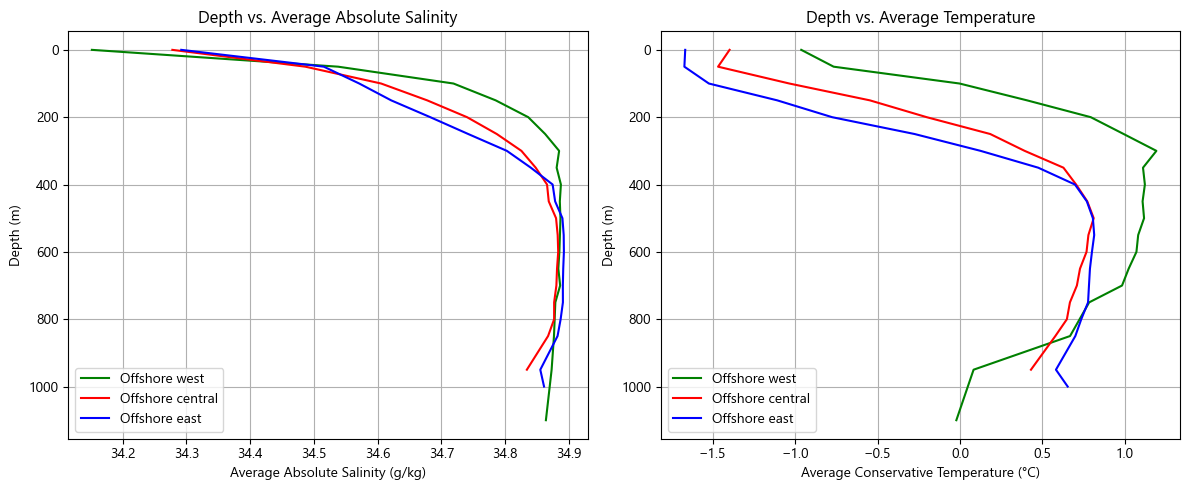

In [202]:
# Create a subplot with two side-by-side plots
plt.figure(figsize=(12, 5))

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 2, 1)
plt.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='green', label='Offshore west')
plt.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='red', label='Offshore central')
plt.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='blue', label='Offshore east')
plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()

# Plot the second subplot (Average Temperature vs. Depth)
plt.subplot(1, 2, 2)
plt.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='green', label='Offshore west')
plt.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='red', label='Offshore central')
plt.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='blue', label='Offshore east')
plt.xlabel('Average Conservative Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Temperature')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

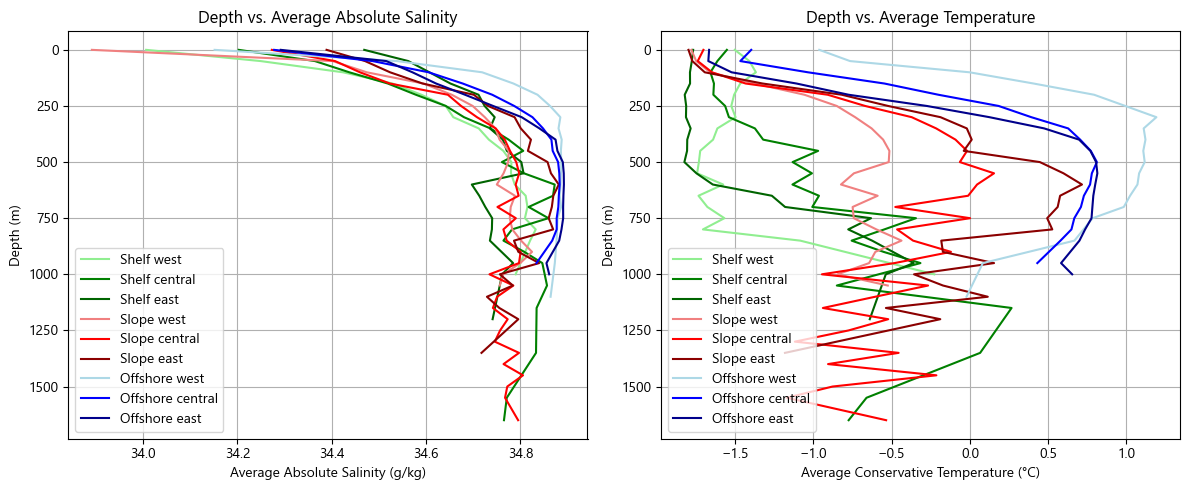

In [221]:
# Create a subplot with two side-by-side plots all 9 sections
plt.figure(figsize=(12, 5))



# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 2, 1)

plt.plot(average_abs_salinity_shelf_west, average_depth_shelf_west, color='lightgreen', label='Shelf west')
plt.plot(average_abs_salinity_shelf_central, average_depth_shelf_central, color='green', label='Shelf central')
plt.plot(average_abs_salinity_shelf_east, average_depth_shelf_east, color='darkgreen', label='Shelf east')

plt.plot(average_abs_salinity_slope_west, average_depth_slope_west, color='lightcoral', label='Slope west')
plt.plot(average_abs_salinity_slope_central, average_depth_slope_central, color='red', label='Slope central')
plt.plot(average_abs_salinity_slope_east, average_depth_slope_east, color='darkred', label='Slope east')

plt.plot(average_abs_salinity_offshore_west, average_depth_offshore_west, color='lightblue', label='Offshore west')
plt.plot(average_abs_salinity_offshore_central, average_depth_offshore_central, color='blue', label='Offshore central')
plt.plot(average_abs_salinity_offshore_east, average_depth_offshore_east, color='darkblue', label='Offshore east')

plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()




# Plot the second subplot (Average Temperature vs. Depth)
plt.subplot(1, 2, 2)

plt.plot(average_cons_temperature_shelf_west, average_depth_shelf_west, color='lightgreen', label='Shelf west')
plt.plot(average_cons_temperature_shelf_central, average_depth_shelf_central, color='green', label='Shelf central')
plt.plot(average_cons_temperature_shelf_east, average_depth_shelf_east, color='darkgreen', label='Shelf east')

plt.plot(average_cons_temperature_slope_west, average_depth_slope_west, color='lightcoral', label='Slope west')
plt.plot(average_cons_temperature_slope_central, average_depth_slope_central, color='red', label='Slope central')
plt.plot(average_cons_temperature_slope_east, average_depth_slope_east, color='darkred', label='Slope east')

plt.plot(average_cons_temperature_offshore_west, average_depth_offshore_west, color='lightblue', label='Offshore west')
plt.plot(average_cons_temperature_offshore_central, average_depth_offshore_central, color='blue', label='Offshore central')
plt.plot(average_cons_temperature_offshore_east, average_depth_offshore_east, color='darkblue', label='Offshore east')

plt.xlabel('Average Conservative Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Depth vs. Average Temperature')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()




# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

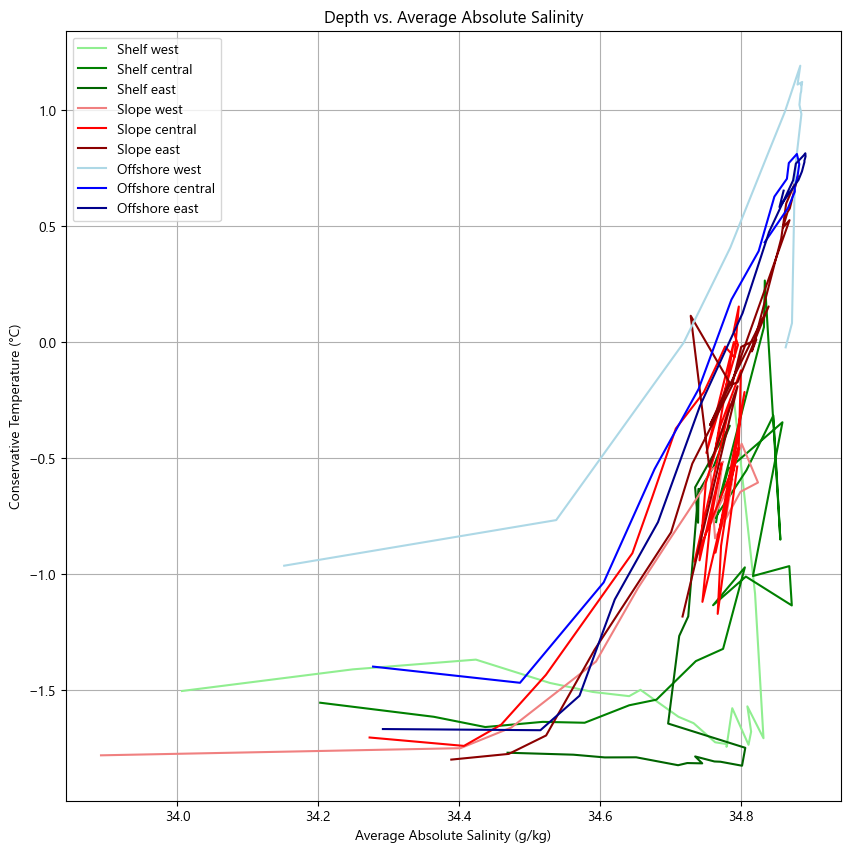

In [227]:
# Create a subplot with two side-by-side plots
plt.figure(figsize=(10, 10))


plt.plot(average_abs_salinity_shelf_west, average_cons_temperature_shelf_west, color='lightgreen', label='Shelf west')
plt.plot(average_abs_salinity_shelf_central, average_cons_temperature_shelf_central, color='green', label='Shelf central')
plt.plot(average_abs_salinity_shelf_east, average_cons_temperature_shelf_east, color='darkgreen', label='Shelf east')

plt.plot(average_abs_salinity_slope_west, average_cons_temperature_slope_west, color='lightcoral', label='Slope west')
plt.plot(average_abs_salinity_slope_central, average_cons_temperature_slope_central, color='red', label='Slope central')
plt.plot(average_abs_salinity_slope_east, average_cons_temperature_slope_east, color='darkred', label='Slope east')

plt.plot(average_abs_salinity_offshore_west, average_cons_temperature_offshore_west, color='lightblue', label='Offshore west')
plt.plot(average_abs_salinity_offshore_central, average_cons_temperature_offshore_central, color='blue', label='Offshore central')
plt.plot(average_abs_salinity_offshore_east, average_cons_temperature_offshore_east, color='darkblue', label='Offshore east')

plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()


# Show the plots
plt.show()

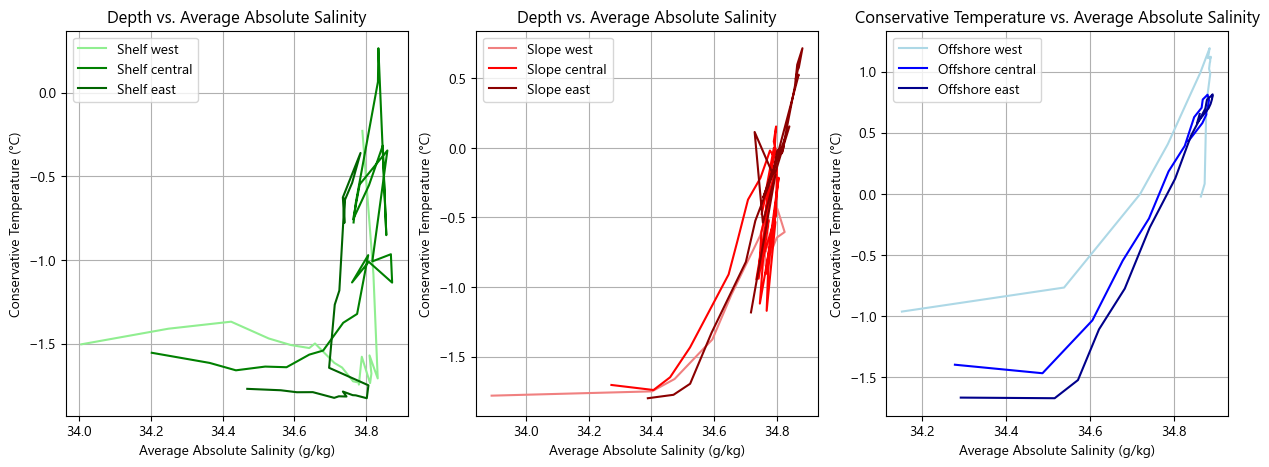

In [233]:
# Create a subplot with two side-by-side plots
plt.figure(figsize=(15, 5))

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 3, 1)

plt.plot(average_abs_salinity_shelf_west, average_cons_temperature_shelf_west, color='lightgreen', label='Shelf west')
plt.plot(average_abs_salinity_shelf_central, average_cons_temperature_shelf_central, color='green', label='Shelf central')
plt.plot(average_abs_salinity_shelf_east, average_cons_temperature_shelf_east, color='darkgreen', label='Shelf east')

plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()


# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 3, 2)

plt.plot(average_abs_salinity_slope_west, average_cons_temperature_slope_west, color='lightcoral', label='Slope west')
plt.plot(average_abs_salinity_slope_central, average_cons_temperature_slope_central, color='red', label='Slope central')
plt.plot(average_abs_salinity_slope_east, average_cons_temperature_slope_east, color='darkred', label='Slope east')

plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 3, 3)
plt.plot(average_abs_salinity_offshore_west, average_cons_temperature_offshore_west, color='lightblue', label='Offshore west')
plt.plot(average_abs_salinity_offshore_central, average_cons_temperature_offshore_central, color='blue', label='Offshore central')
plt.plot(average_abs_salinity_offshore_east, average_cons_temperature_offshore_east, color='darkblue', label='Offshore east')

plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Conservative Temperature vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()



# Show the plots
plt.show()

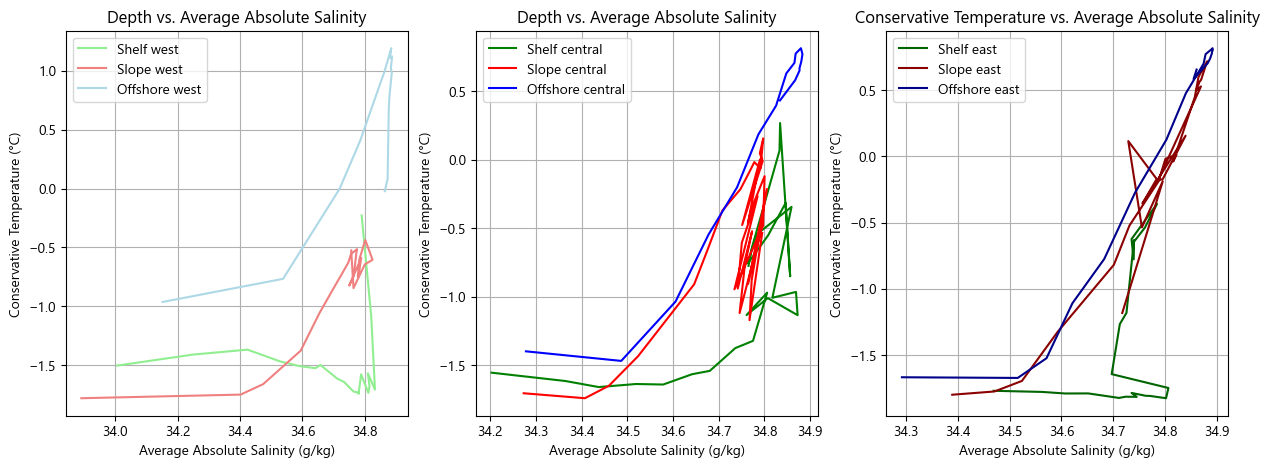

: 

In [234]:
# Create a subplot with two side-by-side plots
plt.figure(figsize=(15, 5))

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 3, 1)

plt.plot(average_abs_salinity_shelf_west, average_cons_temperature_shelf_west, color='lightgreen', label='Shelf west')
plt.plot(average_abs_salinity_slope_west, average_cons_temperature_slope_west, color='lightcoral', label='Slope west')
plt.plot(average_abs_salinity_offshore_west, average_cons_temperature_offshore_west, color='lightblue', label='Offshore west')

plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()


# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 3, 2)

plt.plot(average_abs_salinity_shelf_central, average_cons_temperature_shelf_central, color='green', label='Shelf central')
plt.plot(average_abs_salinity_slope_central, average_cons_temperature_slope_central, color='red', label='Slope central')
plt.plot(average_abs_salinity_offshore_central, average_cons_temperature_offshore_central, color='blue', label='Offshore central')


plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Depth vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()

# Plot the first subplot (Average Absolute Salinity vs. Depth)
plt.subplot(1, 3, 3)

plt.plot(average_abs_salinity_shelf_east, average_cons_temperature_shelf_east, color='darkgreen', label='Shelf east')
plt.plot(average_abs_salinity_slope_east, average_cons_temperature_slope_east, color='darkred', label='Slope east')
plt.plot(average_abs_salinity_offshore_east, average_cons_temperature_offshore_east, color='darkblue', label='Offshore east')


plt.xlabel('Average Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (°C)')
plt.title('Conservative Temperature vs. Average Absolute Salinity')
plt.grid(True)
plt.legend()



# Show the plots
plt.show()

<Figure size 640x480 with 0 Axes>

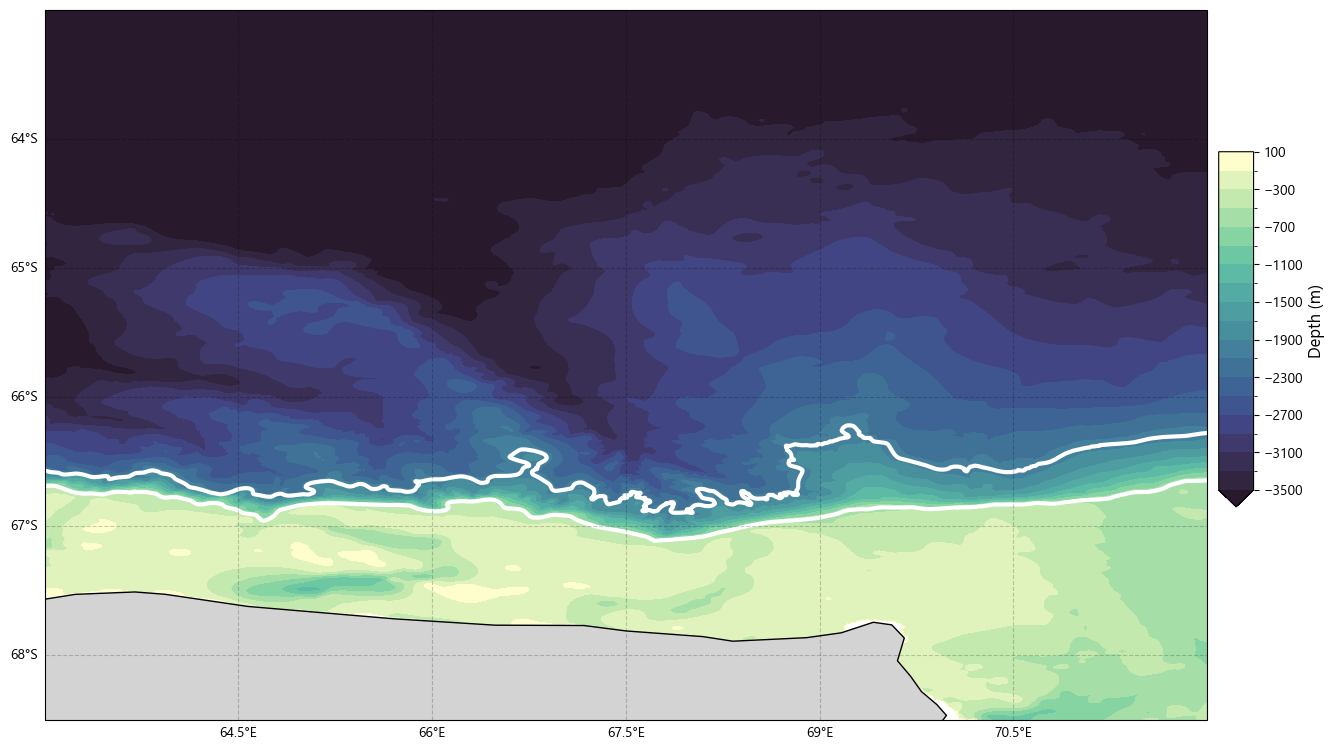

In [99]:
#Both contours on same bathymetry plot

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cmocean


# Open the NetCDF file with xarray
gebco = xr.open_dataset('bathymetry data/netCDF_CD_bathymetry/GEBCO_30_Apr_2023_950e3c1fe0d8/gebco_2022_n-63.0_s-68.5_w62.5_e72.0.nc', engine='netcdf4')



# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='lightgray') # need to find a better land mask than this.
ax.set_extent([63, 72, -68.5, -63])
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Use the custom colormap with light gray color for values >= 0
elevation = gebco.elevation.where(gebco.elevation < 0, np.nan)

#add data
im = elevation.plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3500,200,200)]),add_colorbar=False)

# Add a contour line for the 600m isobath
##contour_line_coordinates comes from 'CTD mapping seals and CTD with type' notebook. 
ax.plot(contour_line_coordinates_shelf[:, 0], contour_line_coordinates_shelf[:, 1], color='white', linewidth=3)
ax.plot(contour_line_coordinates_slope[:, 0], contour_line_coordinates_slope[:, 1], color='white', linewidth=3)

#add colourbar
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='right',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)', fontsize=12)
ax = plt.gca()

plt.show()